# Genomic surveillance analysis in Germany

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpyro as npy
import numpyro.distributions as dist
import pandas as pd
from jax import random
import geopandas as gpd
import genomicsurveillance as gs ## misc branch on github

assert npy.__version__.startswith("0.8.0")
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'axes.grid': True,
                     'grid.linestyle': ':',
                     'axes.spines.bottom': False,
          'axes.spines.left': False,
          'axes.spines.right': False,
          'axes.spines.top': False})

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


In [2]:
from genomicsurveillance.misc import ancestor_matrix, alias

## Download data
### Map
With zip codes for geo matching

In [3]:
#plz = gpd.read_file("https://opendata.arcgis.com/datasets/5b203df4357844c8a6715d7d411a8341_0.geojson")
if 'plz' not in locals():
    plz = gpd.read_file("data/5b203df4357844c8a6715d7d411a8341_0.geojson")
    bland = plz.set_index("plz")['bundesland']

### Sequences
From RKI's Github

In [4]:
! bash scripts/pipeline.sh

+ bash scripts/download_data.sh
+ mkdir -p data/compressed
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Sequenzdaten_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 61.7M  100 61.7M    0     0  8143k      0  0:00:07  0:00:07 --:--:-- 9327k
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Entwicklungslinien_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 23.1M  100 23.1M    0     0  6447k      0  0:00:03  0:00:03 --:--:-- 8048k
+ bash scripts/

In [5]:
df = pd.read_csv(
    'data/meta_lineages.csv',
    index_col=0,
    parse_dates=[1,3],
    infer_datetime_format=True,
    cache_dates=True,
    dtype = {'SEQ_REASON': 'category',
             'SENDING_LAB_PC': 'category',
             'SEQUENCING_LAB_PC': 'category',
             'lineage': 'category',
             'scorpio_call': 'category'
             }
)
df.rename(columns={
    'DATE_DRAW': 'date',
    'PROCESSING_DATE': 'processing_date',
    'SEQ_REASON': 'reason',
    'SENDING_LAB_PC': 'sending_pc',
    'SEQUENCING_LAB_PC': 'sequencing_pc',
    'lineage': 'lineage',
    'scorpio_call': 'scorpio'
    },
    inplace=True
)

In [6]:
df = df[~ pd.isna(df.sending_pc)]
df.sending_pc = df.sending_pc.cat.rename_categories({x:f"{float(x):05.0f}" for x in df.sending_pc.cat.categories}) # = df.sending_pc.astype('str').astype('category')


In [7]:

df = df.merge(bland, left_on='sending_pc', right_index=True)#.dropna()


In [8]:
df.reason.value_counts()

N                       594610
X                       340249
Y                        40182
A[B.1.617.2]             35864
A[B.1.1.7]               35832
                         ...  
A[B1.1.529]                  0
A[E484K/N501Y/P681R]         0
A[E484E/N501N/P681R]         0
A[E484E/N501N/P681P]         0
A[N501Y/E484K]               0
Name: reason, Length: 235, dtype: int64

In [9]:
import re

In [10]:
df

date reason  \
IMS_ID                                                                 
IMS-10294-CVDP-00001                               2021-01-14      X   
IMS-10294-CVDP-00325                               2020-11-08      X   
IMS-10294-CVDP-00326                               2020-11-08      X   
IMS-10294-CVDP-00327                               2020-11-08      X   
IMS-10294-CVDP-00329                               2020-11-09      X   
...                                                       ...    ...   
IMS-10594-CVDP-CE8299E7-659A-476E-B2A2-5DBB2BCD... 2022-08-23      Y   
IMS-10594-CVDP-76A84CA4-0B43-4F05-BEED-F76CF7F9... 2022-08-30      Y   
IMS-10594-CVDP-45DCC9DB-98F1-4770-896C-8CAE1C40... 2022-08-30      Y   
IMS-10594-CVDP-FA5ACBE9-879E-4967-9251-8B4E3890... 2022-08-30      Y   
IMS-10184-CVDP-6BE4FE02-67B1-43BE-AA67-8EA60823... 2022-08-16      N   

                                                   processing_date sending_pc  \
IMS_ID                                                                          
IMS-10294-CVDP-00001                                    2021-01-25      40225   
IMS-10294-CVDP-00325                                    2021-02-14      40225   
IMS-10294-CVDP-00326                                    2021-02-14      40225   
IMS-10294-CVDP-00327                                    2021-02-14      40225   
IMS-10294-CVDP-00329                                    2021-02-14      40225   
...                                                            ...        ...   
IMS-10594-CVDP-CE8299E7-659A-476E-B2A2-5DBB2BCD...      2022-09-21      55131   
IMS-10594-CVDP-76A84CA4-0B43-4F05-BEED-F76CF7F9...      2022-09-21      55131   
IMS-10594-CVDP-45DCC9DB-98F1-4770-896C-8CAE1C40...      2022-09-21      55131   
IMS-10594-CVDP-FA5ACBE9-879E-4967-9251-8B4E3890...      2022-09-21      55131   
IMS-10184-CVDP-6BE4FE02-67B1-43BE-AA67-8EA60823...      2022-08-22      33617   

                                                   sequencing_pc    lineage  \
IMS_ID                                                                        
IMS-10294-CVDP-00001                                       40225  B.1.1.297   
IMS-10294-CVDP-00325                                       40225    B.1.221   
IMS-10294-CVDP-00326                                       40225    B.1.160   
IMS-10294-CVDP-00327                                       40225    B.1.258   
IMS-10294-CVDP-00329                                       40225  B.1.1.521   
...                                                          ...        ...   
IMS-10594-CVDP-CE8299E7-659A-476E-B2A2-5DBB2BCD...         55131   BA.5.1.2   
IMS-10594-CVDP-76A84CA4-0B43-4F05-BEED-F76CF7F9...         55131     BA.5.1   
IMS-10594-CVDP-45DCC9DB-98F1-4770-896C-8CAE1C40...         55131   BA.5.1.2   
IMS-10594-CVDP-FA5ACBE9-879E-4967-9251-8B4E3890...         55131   BA.5.1.2   
IMS-10184-CVDP-6BE4FE02-67B1-43BE-AA67-8EA60823...         24106     BA.5.2   

                                                   scorpio  \
IMS_ID                                                       
IMS-10294-CVDP-00001                                   NaN   
IMS-10294-CVDP-00325                                   NaN   
IMS-10294-CVDP-00326                                   NaN   
IMS-10294-CVDP-00327                                   NaN   
IMS-10294-CVDP-00329                                   NaN   
...                                                    ...   
IMS-10594-CVDP-CE8299E7-659A-476E-B2A2-5DBB2BCD...     NaN   
IMS-10594-CVDP-76A84CA4-0B43-4F05-BEED-F76CF7F9...     NaN   
IMS-10594-CVDP-45DCC9DB-98F1-4770-896C-8CAE1C40...     NaN   
IMS-10594-CVDP-FA5ACBE9-879E-4967-9251-8B4E3890...     NaN   
IMS-10184-CVDP-6BE4FE02-67B1-43BE-AA67-8EA60823...     NaN   

                                                             bundesland  
IMS_ID                                                                   
IMS-10294-CVDP-00001                                Nordrhein-Westfalen  
IMS-10294

In [11]:
df.lineage[df.date > np.datetime64("today") - np.timedelta64(30, "D")].cat.remove_unused_categories().value_counts()

BA.5.2      3303
BA.5.1      2364
BA.5.2.1    1737
BE.1.1      1172
BF.7         924
            ... 
BA.1.1         1
BA.4.1.6       1
BA.2.3.7       1
BA.2.9         1
BA.5.10        1
Name: lineage, Length: 82, dtype: int64

In [12]:
start_date = "2021-01-01"
d = df.loc[df.date >= start_date,:]
d = d[d.reason.isin(['N','X'])]
d = d[d.lineage != "None"]
d.lineage = d.lineage.cat.remove_unused_categories().cat.add_categories(['Other'])
l = d.lineage.cat.categories#remove_unused_categories()

In [13]:
ba = [x for x in l if alias(x, anti_alias=True).startswith('B.1.1.529') ]
#ba

In [14]:
#d.lineage[d.lineage.isna()] = 'Other'
#d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529']),"lineage"] = "Delta/Other"
#d.lineage.iloc[d.lineage.apply(lambda x: re.match("AY",x) is not None).astype("Bool")] = "B.1.617.2"
#d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529','B.1.617.2'] + ba),"lineage"] = "Other"
d.lineage = d.lineage.cat.remove_unused_categories()#.cat.add_categories(['BA.2.40'])
genomes = pd.crosstab(index=[d.bundesland, d.date], columns=d.lineage, dropna=False).fillna(0)
#genomes.loc["Baden-Württemberg"]
genomes = genomes.iloc[:,[(i + 1) % genomes.shape[1] for i in range(genomes.shape[1])]]
genomes

lineage                       A.19  A.2.5  A.2.5.2  A.23.1  A.27  A.28  A.29  \
bundesland        date                                                         
Baden-Württemberg 2021-01-01     0      0        0       0     0     0     0   
                  2021-01-02     0      0        0       0     0     0     0   
                  2021-01-03     0      0        0       0     0     0     0   
                  2021-01-04     0      0        0       0     0     0     0   
                  2021-01-05     0      0        0       0     0     0     0   
...                            ...    ...      ...     ...   ...   ...   ...   
Thüringen         2022-09-22     0      0        0       0     0     0     0   
                  2022-09-23     0      0        0       0     0     0     0   
                  2022-09-25     0      0        0       0     0     0     0   
                  2022-09-26     0      0        0       0     0     0     0   
                  2022-09-29     0      0        0       0     0     0     0   

lineage                       AA.1  AF.1  AG.1  ...  BA.5.6.1  BA.5.6.2  \
bundesland        date                          ...                       
Baden-Württemberg 2021-01-01     0     0     0  ...         0         0   
                  2021-01-02     0     0     0  ...         0         0   
                  2021-01-03     0     0     0  ...         0         0   
                  2021-01-04     0     0     0  ...         0         0   
                  2021-01-05     0     0     0  ...         0         0   
...                            ...   ...   ...  ...       ...       ...   
Thüringen         2022-09-22     0     0     0  ...         0         0   
                  2022-09-23     0     0     0  ...         0         0   
                  2022-09-25     0     0     0  ...         0         0   
                  2022-09-26     0     0     0  ...         0         0   
                  2022-09-29     0     0     0  ...         0         0   

lineage                       BE.1.2  BF.13  BF.9  BH.1  BK.1  XAJ  BA.2.10.4  \
bundesland        date                                                          
Baden-Württemberg 2021-01-01       0      0     0     0     0    0          0   
                  2021-01-02       0      0     0     0     0    0          0   
                  2021-01-03       0      0     0     0     0    0          0   
                  2021-01-04       0      0     0     0     0    0          0   
                  2021-01-05       0      0     0     0     0    0          0   
...                              ...    ...   ...   ...   ...  ...        ...   
Thüringen         2022-09-22       0      0     0     0     0    0          0   
                  2022-09-23       0      0     0     0     0    0          0   
                  2022-09-25       0      0     0     0     0    0          0   
                  2022-09-26       0      0     0     0     0    0          0   
                  2022-09-29       0      0     0     0     0    0          0   

lineage                       A  
bundesland        date           
Baden-Württemberg 2021-01-01  0  
                  2021-01-02  0  
                  2021-01-03  0  
                  2021-01-04  0  
                  2021-01-05  0  
...                          ..  
Thüringen         2022-09-22  0  
                  2022-09-23  0  
                  2022-09-25  0  
                  2022-09-26  0  
                  2022-09-29  0  

[10144 rows x 711 columns]

In [15]:
with pd.option_context('display.max_rows', None,):
    print(genomes.sum(level=1).loc["2022-06-01":,[x for x in genomes.columns if x.startswith("BA.2.75")]])

lineage     BA.2.75  BA.2.75.1  BA.2.75.2  BA.2.75.5
date                                                
2022-06-01        0          0          0          0
2022-06-02        0          0          0          0
2022-06-03        1          0          0          0
2022-06-04        0          0          0          0
2022-06-05        0          0          0          0
2022-06-06        1          0          0          0
2022-06-07        0          0          0          0
2022-06-08        0          0          0          0
2022-06-09        0          0          0          0
2022-06-10        0          0          0          0
2022-06-11        0          0          0          0
2022-06-12        0          0          0          0
2022-06-13        0          0          0          0
2022-06-14        0          0          0          0
2022-06-15        0          0          0          0
2022-06-16        0          0          0          0
2022-06-17        0          0          0     

Text(0, 0.5, '14d log odds Aug 1-15 / Jul 15-30')

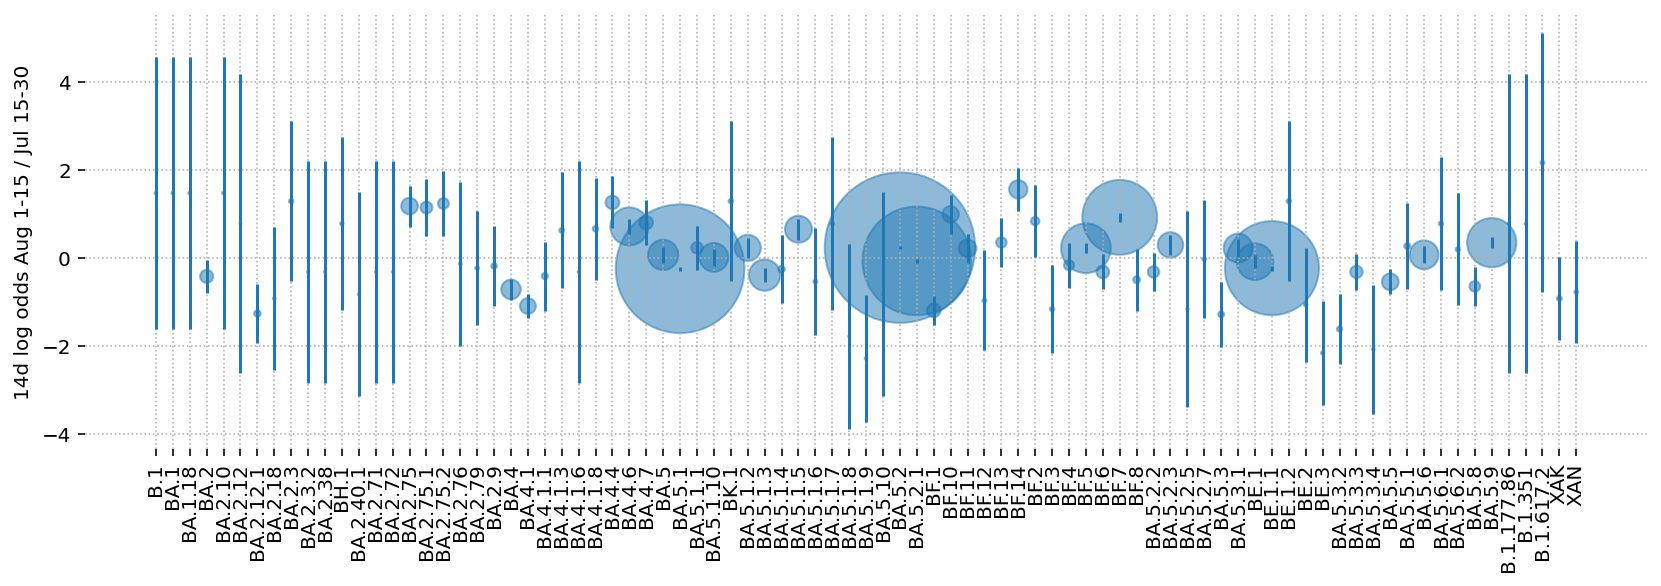

In [16]:
g = genomes.sum(level=1)
g.columns =  [alias(alias(x, anti_alias=True)) for x in g.columns]
h = g.iloc[-28:].sum(0) #+.5
i = g.iloc[-56:-28].sum(0) +.5
f = h[h>0]/i[h>0] * i.sum()/h.sum()
f.index = [alias(x, anti_alias=True) for x in f.index]
f = f.sort_index()
f.index = [alias(x) for x in f.index]
n = h[h>0]
e = np.sqrt(1./h[h>0] + 1./i[h>0] + 1./i.sum() + 1./h.sum())
#e.index = [alias(alias(x, anti_alias=True)) for x in e.index]
plt.figure(figsize=(14,4))
plt.scatter(f.index, np.log(f), s=n[f.index], alpha=0.5)
plt.errorbar(f.index, np.log(f), yerr=1.96*e[f.index], ls="")
_ = plt.xticks(rotation=90)
plt.ylabel("14d log odds Aug 1-15 / Jul 15-30")

Text(0, 0.5, 'Fold change')

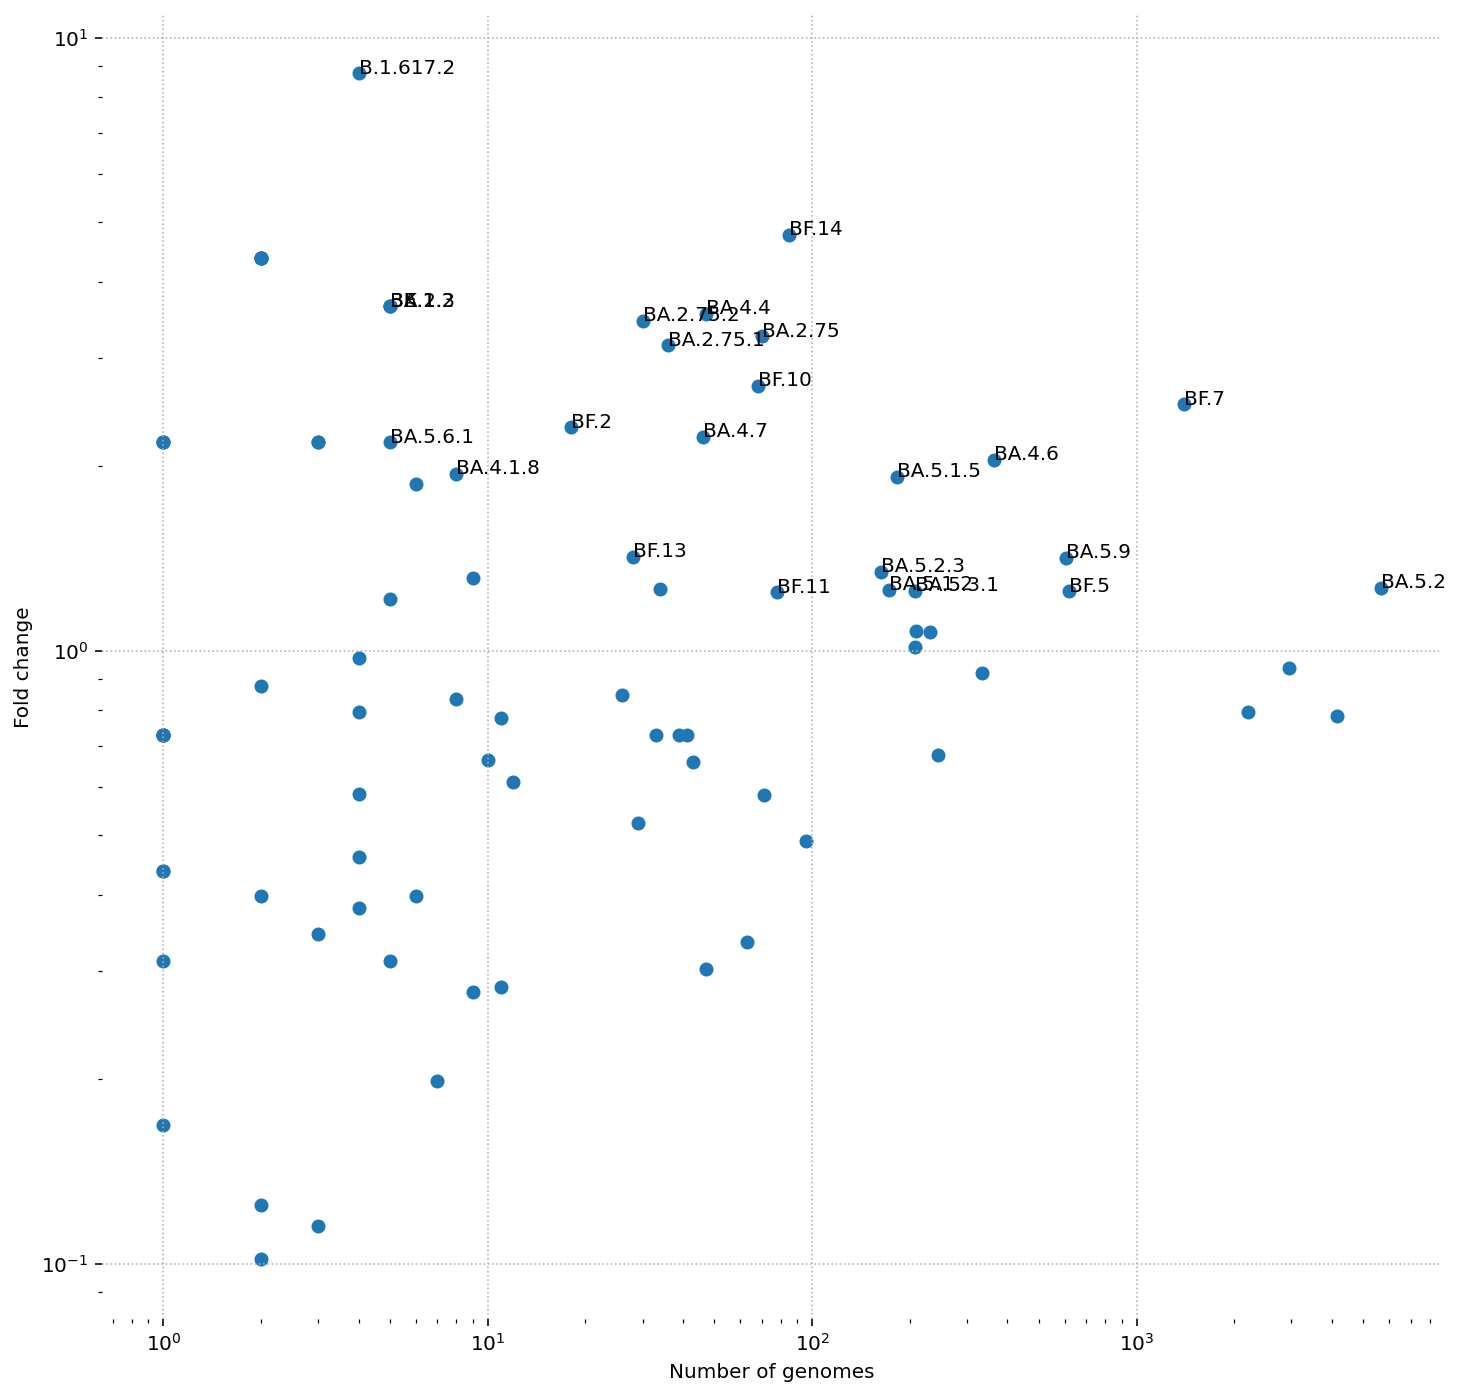

In [17]:
plt.figure(figsize=(12,12))
plt.scatter(n[f.index],f)
for l in f.index:
    if np.log(f[l]) > e[l]:
        plt.text(x=n[l], y=f[l], s=l)
plt.yscale('log')
plt.xlabel("Number of genomes")
plt.xscale('log')
plt.ylabel("Fold change")

(19083.0, 19295.8)

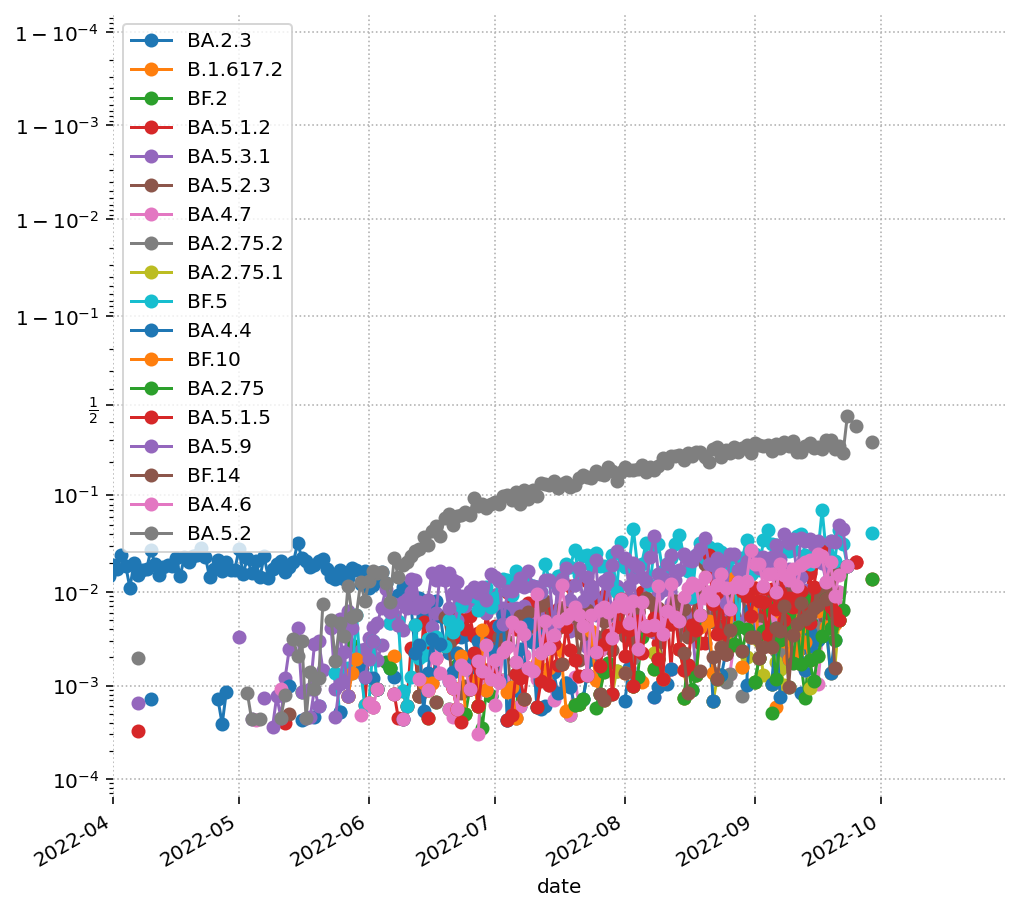

In [18]:
plt.figure(figsize=(8,8))
plt.set_cmap('tab20')
for i,v in enumerate((np.log(f)/e[f.index]).sort_values()[-20:-1].index.to_list() ):
    if g[v].sum()>=20:
        (g[v]/g.sum(1)+0).plot(label=v, ls="-", marker="o")
plt.yscale('logit')
#plt.show()
plt.legend()
plt.xlim(("2022-04-01",None))

In [19]:
url = "https://dev-lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?country=Germany&dateFrom=2022-06-20&nextcladePangoLineage=bq.1&host=Human&accessKey=9Cb3CqmrFnVjO3XCxQLO6gUnKPd&fields=date"
import json, requests
foo = json.loads(requests.get(url).text)['data']
foo

[{'date': '2022-09-15', 'count': 2},
 {'date': '2022-09-03', 'count': 1},
 {'date': '2022-09-05', 'count': 2},
 {'date': '2022-09-07', 'count': 3},
 {'date': '2022-08-23', 'count': 1},
 {'date': '2022-09-08', 'count': 1},
 {'date': '2022-08-24', 'count': 1},
 {'date': '2022-09-09', 'count': 3},
 {'date': '2022-09-11', 'count': 3},
 {'date': '2022-09-12', 'count': 3}]

In [20]:
bar = pd.DataFrame.from_dict(foo).set_index('date')
bar.index = pd.DatetimeIndex(bar.index)
bq1 = pd.merge(bar,genomes.loc['Baden-Württemberg'],left_index=True, right_index=True, how='right')['count'].fillna(0).astype('int')
bq1

date
2021-01-01    0
2021-01-02    0
2021-01-03    0
2021-01-04    0
2021-01-05    0
             ..
2022-09-22    0
2022-09-23    0
2022-09-25    0
2022-09-26    0
2022-09-29    0
Name: count, Length: 634, dtype: int64

In [21]:
url = "https://dev-lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?country=Germany&dateFrom=2022-06-20&nextcladePangoLineage=bq.1*&aaMutations=S%3A346T&host=Human&accessKey=9Cb3CqmrFnVjO3XCxQLO6gUnKPd&fields=date"
import json, requests
foo = json.loads(requests.get(url).text)['data']
foo

[{'date': '2022-09-15', 'count': 3},
 {'date': '2022-09-17', 'count': 3},
 {'date': '2022-09-19', 'count': 2},
 {'date': '2022-08-24', 'count': 1},
 {'date': '2022-09-09', 'count': 1},
 {'date': '2022-09-10', 'count': 1},
 {'date': '2022-09-11', 'count': 1}]

In [22]:
bar = pd.DataFrame.from_dict(foo).set_index('date')
bar.index = pd.DatetimeIndex(bar.index)
bq11 = pd.merge(bar,genomes.loc['Baden-Württemberg'],left_index=True, right_index=True, how='right')['count'].fillna(0).astype('int')
bq11

date
2021-01-01    0
2021-01-02    0
2021-01-03    0
2021-01-04    0
2021-01-05    0
             ..
2022-09-22    0
2022-09-23    0
2022-09-25    0
2022-09-26    0
2022-09-29    0
Name: count, Length: 634, dtype: int64

In [23]:
genomes.columns=genomes.columns.add_categories(['BQ.1','BQ.1.1'])

In [24]:
genomes.insert(0,column='BQ.1.1', value=0)
genomes.loc['Baden-Württemberg']['BQ.1.1'] = bq11
genomes.loc['Baden-Württemberg']['BA.5'] -= bq11 

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
genomes.insert(0,column='BQ.1', value=0)
genomes.loc['Baden-Württemberg']['BQ.1'] = bq1
genomes.loc['Baden-Württemberg']['BA.5'] -= bq1

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
genomes.loc['Baden-Württemberg'][['BQ.1','BQ.1.1']] 

lineage     BQ.1  BQ.1.1
date                    
2021-01-01     0       0
2021-01-02     0       0
2021-01-03     0       0
2021-01-04     0       0
2021-01-05     0       0
...          ...     ...
2022-09-22     0       0
2022-09-23     0       0
2022-09-25     0       0
2022-09-26     0       0
2022-09-29     0       0

[634 rows x 2 columns]

In [27]:
url = "https://dev-lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?country=Germany&dateFrom=2022-06-20&nextcladePangoLineage=ba.2.3.20&host=Human&accessKey=9Cb3CqmrFnVjO3XCxQLO6gUnKPd&fields=date"
import json, requests
foo = json.loads(requests.get(url).text)['data']
foo

[{'date': '2022-09-14', 'count': 2}, {'date': '2022-09-05', 'count': 1}]

In [28]:
genomes.loc["Sachsen", "2022-02-20"]["BA.4"] = 0 ## Remove outlier

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/pandas/core/series.py:1008: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [29]:
genomes.index.levels[0]

Index(['Baden-Württemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hessen', 'Mecklenburg-Vorpommern', 'Niedersachsen',
       'Nordrhein-Westfalen', 'Rheinland-Pfalz', 'Saarland', 'Sachsen',
       'Sachsen-Anhalt', 'Schleswig-Holstein', 'Thüringen'],
      dtype='object', name='bundesland')

In [30]:
genomes.loc[:,"BA.2.75"].sum(level=0)

bundesland
Baden-Württemberg         39
Bayern                    19
Berlin                     3
Brandenburg                2
Bremen                     0
Hamburg                    3
Hessen                     0
Mecklenburg-Vorpommern     2
Niedersachsen              9
Nordrhein-Westfalen       17
Rheinland-Pfalz            2
Saarland                   1
Sachsen                    6
Sachsen-Anhalt             0
Schleswig-Holstein         4
Thüringen                  0
Name: BA.2.75, dtype: int64

In [31]:
import importlib
importlib.reload(gs.utils)
importlib.reload(gs)
from genomicsurveillance.utils import preprocess_lineage_tensor

In [32]:
G = genomes.values.reshape([len(genomes.index.levels[0]), len(genomes.index.levels[1]), -1])

In [33]:
lineages = genomes.columns.to_list()

In [34]:
pattern=re.compile(r"[A-Z]+(\.\d+)*$")
pattern.match(lineages[1])

<re.Match object; span=(0, 6), match='BQ.1.1'>

In [35]:
foo =d.lineage.value_counts()[:200]
bar = [d.date[d.lineage==l].sort_values()[10] for l in foo.index]
bak = pd.DataFrame({'counts':foo, 'date':bar})

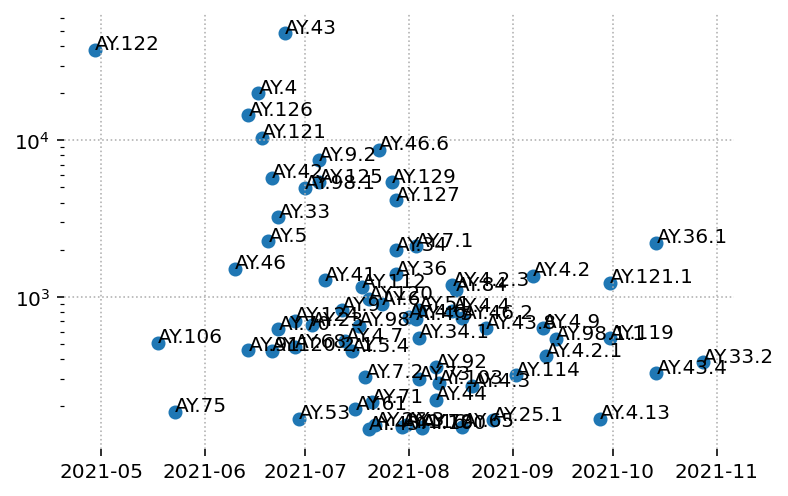

In [36]:
ay = bak.loc[bak.index.str.match('AY')]
plt.scatter(ay.date, ay.counts)
for i in ay.index:
    plt.text(bak.date[i], bak.counts[i], i)
plt.yscale('log')

In [37]:
vocs = ["B.1.1.529","BA.1","BA.1.1","BA.2","BA.4","BA.5","BA.5.2","BA.2.12.1","BA.2.75", "BA.2.75.1","BA.2.75.2","BA.4.6", "BF.7", "BF.11", "BF.13", "BF.14","BQ.1","BQ.1.1"] + ["B.1.1.7","B.1.1.318","B.1.621","B.1.525","B.1.351","P.1","AY.43","AY.46.6","AY.4.2","AY.36.1"]

In [38]:
merged_lineages, G, _ = preprocess_lineage_tensor(lineage_tensor=G, 
                                                     lineage_list=[alias(x, anti_alias=True) for x in lineages], 
                                                     vocs=[alias(x, anti_alias=True) for x in lineages if x in vocs], #any([y in x for y in ["BA.4","BA.5","BA.2.12.1"]])], 
                                                     cutoff=100000)
merged_lineages

Dropped lineages []


['A',
 'B',
 'B.1.1.7',
 'B.1.1.28.1',
 'B.1.1.318',
 'B.1.1.529',
 'B.1.1.529.1',
 'B.1.1.529.1.1',
 'B.1.1.529.2',
 'B.1.1.529.2.12.1',
 'B.1.1.529.2.75',
 'B.1.1.529.2.75.1',
 'B.1.1.529.2.75.2',
 'B.1.1.529.4',
 'B.1.1.529.4.6',
 'B.1.1.529.5',
 'B.1.1.529.5.2',
 'B.1.1.529.5.2.1.7',
 'B.1.1.529.5.2.1.11',
 'B.1.1.529.5.2.1.13',
 'B.1.1.529.5.2.1.14',
 'B.1.1.529.5.3.1.1.1.1.1',
 'B.1.1.529.5.3.1.1.1.1.1.1',
 'B.1.351',
 'B.1.525',
 'B.1.617.2',
 'B.1.617.2.4.2',
 'B.1.617.2.36.1',
 'B.1.617.2.43',
 'B.1.617.2.46.6',
 'B.1.621',
 'XAB',
 'XAD',
 'XAF',
 'XAG',
 'XAH',
 'XAJ',
 'XAK',
 'XAL',
 'XAM',
 'XAN',
 'XAP',
 'XAS',
 'XAU',
 'XB',
 'XD',
 'XE',
 'XG',
 'XH',
 'XJ',
 'XM',
 'XV',
 'XW',
 'XZ']

In [39]:
G.sum((0,1))

array([6.93000e+02, 3.10940e+04, 9.77030e+04, 9.23000e+02, 1.17300e+03,
       1.52600e+03, 5.74510e+04, 1.09835e+05, 2.61257e+05, 3.92500e+03,
       1.08000e+02, 5.20000e+01, 3.90000e+01, 6.48500e+03, 8.00000e+02,
       7.59730e+04, 3.86960e+04, 2.31700e+03, 1.74000e+02, 5.10000e+01,
       1.10000e+02, 2.00000e+01, 1.20000e+01, 1.97900e+03, 8.60000e+02,
       1.75420e+05, 3.09900e+03, 2.22100e+03, 4.91790e+04, 8.70100e+03,
       1.65000e+02, 1.27000e+02, 9.00000e+01, 2.00000e+00, 5.00000e+00,
       5.00000e+00, 1.00000e+00, 1.27000e+02, 9.80000e+01, 6.00000e+00,
       2.80000e+01, 1.00000e+00, 1.00000e+00, 2.00000e+00, 5.00000e+00,
       1.00000e+00, 4.90000e+01, 4.60000e+01, 3.00000e+00, 1.00000e+00,
       3.79000e+02, 1.00000e+00, 5.30000e+01, 3.00000e+00])

In [40]:
baseline = 'B'
o = [merged_lineages.index(x) for x in merged_lineages if x != baseline and not x.startswith("X")] + [merged_lineages.index(baseline)]
G = G[:,:,o]
merged_lineages = [merged_lineages[x] for x in o]
merged_lineages

['A',
 'B.1.1.7',
 'B.1.1.28.1',
 'B.1.1.318',
 'B.1.1.529',
 'B.1.1.529.1',
 'B.1.1.529.1.1',
 'B.1.1.529.2',
 'B.1.1.529.2.12.1',
 'B.1.1.529.2.75',
 'B.1.1.529.2.75.1',
 'B.1.1.529.2.75.2',
 'B.1.1.529.4',
 'B.1.1.529.4.6',
 'B.1.1.529.5',
 'B.1.1.529.5.2',
 'B.1.1.529.5.2.1.7',
 'B.1.1.529.5.2.1.11',
 'B.1.1.529.5.2.1.13',
 'B.1.1.529.5.2.1.14',
 'B.1.1.529.5.3.1.1.1.1.1',
 'B.1.1.529.5.3.1.1.1.1.1.1',
 'B.1.351',
 'B.1.525',
 'B.1.617.2',
 'B.1.617.2.4.2',
 'B.1.617.2.36.1',
 'B.1.617.2.43',
 'B.1.617.2.46.6',
 'B.1.621',
 'B']

In [41]:
merged_lineages_alias = [alias(x) for x in merged_lineages]
merged_lineages_alias

['A',
 'B.1.1.7',
 'P.1',
 'B.1.1.318',
 'B.1.1.529',
 'BA.1',
 'BA.1.1',
 'BA.2',
 'BA.2.12.1',
 'BA.2.75',
 'BA.2.75.1',
 'BA.2.75.2',
 'BA.4',
 'BA.4.6',
 'BA.5',
 'BA.5.2',
 'BF.7',
 'BF.11',
 'BF.13',
 'BF.14',
 'BQ.1',
 'BQ.1.1',
 'B.1.351',
 'B.1.525',
 'B.1.617.2',
 'AY.4.2',
 'AY.36.1',
 'AY.43',
 'AY.46.6',
 'B.1.621',
 'B']

In [42]:
dict(zip(merged_lineages_alias,G.sum((0,1))))

{'A': 693.0,
 'B.1.1.7': 97703.0,
 'P.1': 923.0,
 'B.1.1.318': 1173.0,
 'B.1.1.529': 1526.0,
 'BA.1': 57451.0,
 'BA.1.1': 109835.0,
 'BA.2': 261257.0,
 'BA.2.12.1': 3925.0,
 'BA.2.75': 108.0,
 'BA.2.75.1': 52.0,
 'BA.2.75.2': 39.0,
 'BA.4': 6485.0,
 'BA.4.6': 800.0,
 'BA.5': 75973.0,
 'BA.5.2': 38696.0,
 'BF.7': 2317.0,
 'BF.11': 174.0,
 'BF.13': 51.0,
 'BF.14': 110.0,
 'BQ.1': 20.0,
 'BQ.1.1': 12.0,
 'B.1.351': 1979.0,
 'B.1.525': 860.0,
 'B.1.617.2': 175420.0,
 'AY.4.2': 3099.0,
 'AY.36.1': 2221.0,
 'AY.43': 49179.0,
 'AY.46.6': 8701.0,
 'B.1.621': 165.0,
 'B': 31094.0}

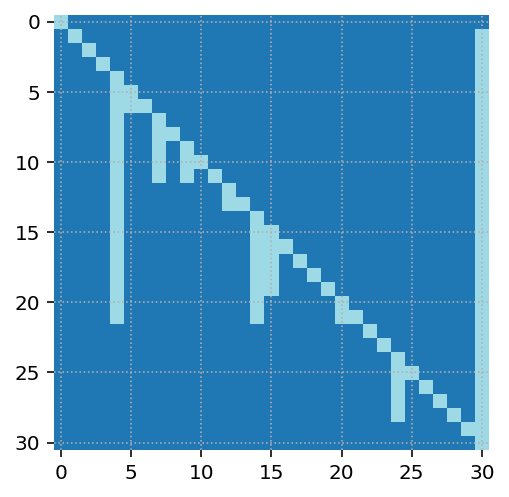

In [43]:
A = ancestor_matrix(merged_lineages)
plt.imshow(A)

In [44]:
#A[1:-1,merged_lineages.index("B.1.1.7")] = 1
#A[merged_lineages.index('B.1.1.529'):-4,merged_lineages.index("B.1.617.2")] = 1
#plt.imshow(A)

### Cases
Also from RKI

In [45]:
cases_raw = pd.read_csv("https://github.com/robert-koch-institut/SARS-CoV-2-Infektionen_in_Deutschland/blob/main/Aktuell_Deutschland_SarsCov2_Infektionen.csv?raw=true",  index_col=[0,1,2,4], parse_dates=True)

In [46]:
cases_raw

Meldedatum  \
IdLandkreis Altersgruppe Geschlecht Refdatum                 
1001        A15-A34      M          2020-01-19  2020-10-28   
                                    2020-03-13  2020-03-21   
                                    2020-03-13  2020-03-19   
                                    2020-03-16  2020-03-14   
                                    2020-03-16  2020-03-19   
...                                                    ...   
16077       A35-A59      W          2022-10-06  2022-10-06   
            A05-A14      W          2022-10-06  2022-10-06   
            A15-A34      W          2022-10-06  2022-10-06   
            A80+         W          2022-10-06  2022-10-06   
            A60-A79      W          2022-10-06  2022-10-06   

                                                IstErkrankungsbeginn  \
IdLandkreis Altersgruppe Geschlecht Refdatum                           
1001        A15-A34      M          2020-01-19                     1   
                                    2020-03-13                     1   
                                    2020-03-13                     1   
                                    2020-03-16                     1   
                                    2020-03-16                     1   
...                                                              ...   
16077       A35-A59      W          2022-10-06                     0   
            A05-A14      W          2022-10-06                     0   
            A15-A34      W          2022-10-06                     0   
            A80+         W          2022-10-06                     0   
            A60-A79      W          2022-10-06                     0   

                                                NeuerFall  NeuerTodesfall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                                
1001        A15-A34      M          2020-01-19          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-16          0              -9   
                                    2020-03-16          0              -9   
...                                                   ...             ...   
16077       A35-A59      W          2022-10-06          1              -9   
            A05-A14      W          2022-10-06          1              -9   
            A15-A34      W          2022-10-06          1              -9   
            A80+         W          2022-10-06          1              -9   
            A60-A79      W          2022-10-06          1              -9   

                                                NeuGenesen  AnzahlFall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                             
1001        A15-A34      M          2020-01-19           0           1   
                                    2020-03-13           0           1   
                                    2020-03-13           0           1   
                                    2020-03-16           0           1   
                                    2020-03-16           0           1   
...                                                    ...         ...   
16077       A35-A59      W          2022-10-06          -9          25   
            A05-A14      W          2022-10-06          -9           1   
            A15-A34      W          2022-10-06          -9           6   
            A80+         W          2022-10-06          -9           1   
            A60-A79      W          2022-10-06          -9          17   

                                                AnzahlTodesfall  AnzahlGenesen  
IdLandkreis Altersgruppe Geschlecht Refdatum                                    
1001        A15-A34      M          2020-01-19                0              1  
                                    2020-03-13                0              1  
               

### Registration delays

In [47]:
f = cases_raw.reset_index(level=3)[['Refdatum','Meldedatum','AnzahlFall'] ].reset_index()
f['Delta'] = np.clip(pd.to_datetime(f['Meldedatum']) - f['Refdatum'], np.timedelta64(0,"D"), np.timedelta64(10,"D"))
f['bundesland'] = (f.IdLandkreis/1000).astype("int")

f= f.set_index(["bundesland","IdLandkreis","Altersgruppe","Geschlecht","Refdatum","Delta"]).sum(level=[0,4,5]).sort_index()
f = f.unstack(level=2)["AnzahlFall"].sort_index().loc[:,"2022-08-01":,:]#.loc[:,"2021-11-01":]
f /= f.sum(1).values[:,np.newaxis]

<AxesSubplot:xlabel='bundesland,Refdatum'>

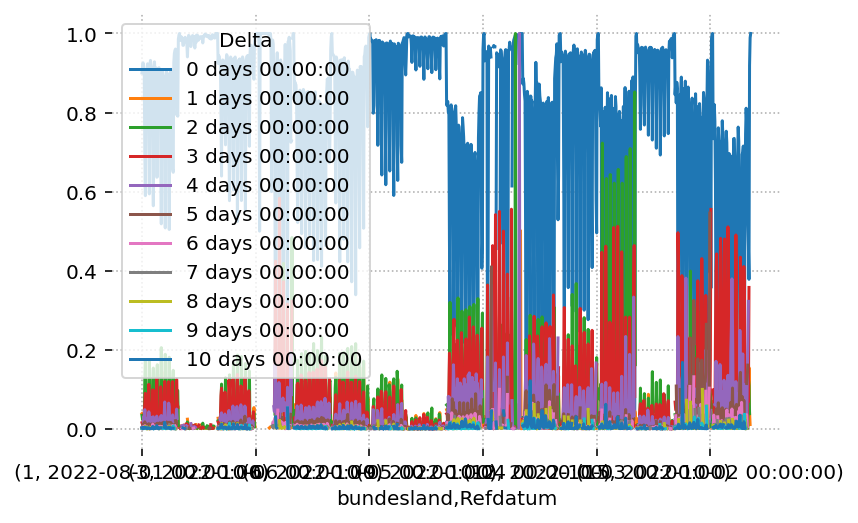

In [48]:
f.plot()

In [49]:
f['weekday'] = f.reset_index()['Refdatum'].dt.strftime("%a").values

In [50]:
f = f.reset_index().set_index(["bundesland","Refdatum","weekday"]).cumsum(1).mean(level=[0,2]).fillna(1)

In [51]:
f.loc[1]

Delta    0 days 00:00:00  1 days 00:00:00  2 days 00:00:00  3 days 00:00:00  \
weekday                                                                       
Mon             0.891355         0.924538         0.965869         0.985886   
Tue             0.923474         0.952691         0.980384         0.989286   
Wed             0.920688         0.951539         0.974840         0.977795   
Thu             0.916748         0.941757         0.950297         0.957521   
Fri             0.903330         0.914188         0.929094         0.961782   
Sat             0.685942         0.722594         0.823558         0.932647   
Sun             0.596438         0.702659         0.867654         0.948236   

Delta    4 days 00:00:00  5 days 00:00:00  6 days 00:00:00  7 days 00:00:00  \
weekday                                                                       
Mon             0.991649         0.992905         0.993736         0.996671   
Tue             0.990233         0.989819         0.995698         0.997445   
Wed             0.979893         0.991632         0.996356         0.998097   
Thu             0.981034         0.992260         0.996130         0.997975   
Fri             0.984956         0.993431         0.996176         0.997434   
Sat             0.977505         0.986651         0.991014         0.989173   
Sun             0.978555         0.987582         0.987188         0.990898   

Delta    8 days 00:00:00  9 days 00:00:00  10 days 00:00:00  
weekday                                                      
Mon             0.998060         0.999018               1.0  
Tue             0.998881         0.999272               1.0  
Wed             0.998921         0.999087               1.0  
Thu             0.998616         0.999279               1.0  
Fri             0.998079         1.000000               1.0  
Sat             0.980978         0.993285               1.0  
Sun             0.994911         0.995661               1.0

In [52]:
reporting_lag = np.array([f.loc[:,d.strftime("%a"),:].iloc[:,(cases_raw.index.levels[3][-1]-d).days] for d in cases_raw.index.levels[3][-9:]]).T

In [53]:
s="""01  Schleswig-Holstein
02  Hamburg
03  Niedersachsen
04  Bremen
05  Nordrhein-Westfalen
06  Hessen
07  Rheinland-Pfalz
08  Baden-Württemberg
09  Bayern
10  Saarland
11  Berlin
12  Brandenburg
13  Mecklenburg-Vorpommern
14  Sachsen
15  Sachsen-Anhalt
16  Thüringen"""
b={int(x.split()[0]): x.split()[1] for x in s.split("\n")}

In [54]:
current_lag = pd.DataFrame(reporting_lag, index=np.arange(1,17)).rename(index=b).sort_index()
current_lag

0         1         2         3         4  \
Baden-Württemberg       0.999881  0.999360  0.999202  0.995665  0.990819   
Bayern                  0.995327  0.992762  0.986321  0.964082  0.925618   
Berlin                  0.994333  0.988837  0.980922  0.932706  0.849674   
Brandenburg             0.999669  0.998250  0.996982  0.977837  0.936642   
Bremen                  1.000000  0.997992  1.000000  0.991667  0.943614   
Hamburg                 1.000000  1.000000  1.000000  0.997268  0.999539   
Hessen                  0.998953  0.997775  0.996442  0.985053  0.963306   
Mecklenburg-Vorpommern  0.997965  0.995888  0.993914  0.954171  0.963284   
Niedersachsen           0.998699  0.998209  0.996929  0.987468  0.966796   
Nordrhein-Westfalen     0.997538  0.996025  0.993239  0.981012  0.959613   
Rheinland-Pfalz         0.999695  0.999441  0.998675  0.991376  0.974370   
Saarland                0.998795  1.000000  0.998450  0.907806  0.947194   
Sachsen                 0.999047  0.999322  0.998648  0.994492  0.985242   
Sachsen-Anhalt          0.997017  0.994217  0.994121  0.931930  0.806219   
Schleswig-Holstein      0.998921  0.997975  0.996176  0.986651  0.978555   
Thüringen               0.994603  0.991929  0.983605  0.957003  0.913644   

                               5         6         7         8  
Baden-Württemberg       0.997727  0.996906  0.994627  0.989830  
Bayern                  0.946532  0.914801  0.838799  0.769694  
Berlin                  0.941144  0.918808  0.887361  0.855583  
Brandenburg             0.985481  0.981392  0.963800  0.948634  
Bremen                  0.990247  0.975697  0.972981  0.955993  
Hamburg                 0.997361  0.998257  0.996162  0.990631  
Hessen                  0.987061  0.972835  0.953070  0.923897  
Mecklenburg-Vorpommern  0.979369  0.956626  0.842810  0.753951  
Niedersachsen           0.988785  0.982389  0.966111  0.939688  
Nordrhein-Westfalen     0.972775  0.952644  0.912245  0.858285  
Rheinland-Pfalz         0.996495  0.993678  0.985684  0.976855  
Saarland                0.967175  0.985414  0.976023  0.958945  
Sachsen                 0.994049  0.991933  0.979625  0.957457  
Sachsen-Anhalt          0.933854  0.924493  0.875849  0.813653  
Schleswig-Holstein      0.985886  0.980384  0.951539  0.916748  
Thüringen               0.926579  0.832855  0.852455  0.746419

In [55]:
cases = cases_raw['AnzahlFall'].sum(level=(0,3)).sort_index()

In [56]:
cases_land = cases.reset_index()
cases_land['bundesland'] = (cases_land.IdLandkreis/1000).astype("int")
cases_land = cases_land.set_index(['bundesland', 'IdLandkreis','Refdatum']).sum(level=(0,2)).sort_index()
cases_land = cases_land.rename(index=b).sort_index()
cases_land = cases_land.loc[:,start_date:,:].unstack()["AnzahlFall"]#.iloc[:,:-1]
#cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / reporting_lag).astype("int32")
cases_land

Refdatum                2021-01-01  2021-01-02  2021-01-03  2021-01-04  \
bundesland                                                               
Baden-Württemberg             1586        1666        1663        2042   
Bayern                        2152        2446        2221        2911   
Berlin                         595         687         687        1006   
Brandenburg                    647         529         542        1096   
Bremen                          30          48          46          55   
Hamburg                        328         375         361         484   
Hessen                        1084         919         959        1174   
Mecklenburg-Vorpommern         178         218         271         485   
Niedersachsen                  874         956         957        1287   
Nordrhein-Westfalen           2264        2600        2552        3695   
Rheinland-Pfalz                541         680         480         712   
Saarland                       144         116         154         233   
Sachsen                       1371        1489        1447        2031   
Sachsen-Anhalt                 691         651         600         782   
Schleswig-Holstein             298         346         318         371   
Thüringen                      615         702         805         923   

Refdatum                2021-01-05  2021-01-06  2021-01-07  2021-01-08  \
bundesland                                                               
Baden-Württemberg             2554        1964        2065        2250   
Bayern                        3602        3026        3271        3585   
Berlin                         981        1008         992         986   
Brandenburg                   1196        1092        1055         907   
Bremen                          81          96         102          81   
Hamburg                        426         379         392         341   
Hessen                        1533        1719        1409        1361   
Mecklenburg-Vorpommern         269         295         221         255   
Niedersachsen                 1505        1649        1300        1312   
Nordrhein-Westfalen           3985        4428        3815        3699   
Rheinland-Pfalz                843         923        1015         903   
Saarland                       242         316         284         241   
Sachsen                       2507        2389        2056        1994   
Sachsen-Anhalt                 802         700         955         866   
Schleswig-Holstein             413         396         392         414   
Thüringen                     1017         922         887        1070   

Refdatum                2021-01-09  2021-01-10  ...  2022-09-27  2022-09-28  \
bundesland                                      ...                           
Baden-Württemberg             1800        1381  ...       14481       11346   
Bayern                        2642        1929  ...       19207       18916   
Berlin                         554         461  ...        2193        2016   
Brandenburg                    752         651  ...        2927        2959   
Bremen                          83          43  ...         694         843   
Hamburg                        237         294  ...        1279        1042   
Hessen                        1132         782  ...        8283        8202   
Mecklenburg-Vorpommern         192         289  ...        1901        1499   
Niedersachsen                 1189         731  ...        9374        8621   
Nordrhein-Westfalen           2760        2163  ...       14706       14426   
Rheinland-Pfalz                662         419  ...        6139        5613   
Saarland                       228         104  ...        1818        1860   
Sachsen                       1235         881  ...        5465        3904   
Sachsen-Anhalt                 536         505  ...        1854        1893   
Schleswig-Holstein             378         294  ...        2661       

In [57]:
cases_land.sum(0)

Refdatum
2021-01-01     13398
2021-01-02     14428
2021-01-03     14063
2021-01-04     19287
2021-01-05     21956
               ...  
2022-10-02     13457
2022-10-03     15872
2022-10-04    115193
2022-10-05    131865
2022-10-06     93985
Length: 644, dtype: int64

In [58]:
clip = 2
cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / current_lag.values)#.astype("int32")
cases_land.loc["Hamburg"].iloc[-2:] = np.nan
cases_land = cases_land.iloc[:,:cases_land.shape[1]-clip]
cases_land

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Refdatum                2021-01-01  2021-01-02  2021-01-03  2021-01-04  \
bundesland                                                               
Baden-Württemberg             1586        1666        1663        2042   
Bayern                        2152        2446        2221        2911   
Berlin                         595         687         687        1006   
Brandenburg                    647         529         542        1096   
Bremen                          30          48          46          55   
Hamburg                        328         375         361         484   
Hessen                        1084         919         959        1174   
Mecklenburg-Vorpommern         178         218         271         485   
Niedersachsen                  874         956         957        1287   
Nordrhein-Westfalen           2264        2600        2552        3695   
Rheinland-Pfalz                541         680         480         712   
Saarland                       144         116         154         233   
Sachsen                       1371        1489        1447        2031   
Sachsen-Anhalt                 691         651         600         782   
Schleswig-Holstein             298         346         318         371   
Thüringen                      615         702         805         923   

Refdatum                2021-01-05  2021-01-06  2021-01-07  2021-01-08  \
bundesland                                                               
Baden-Württemberg             2554        1964        2065        2250   
Bayern                        3602        3026        3271        3585   
Berlin                         981        1008         992         986   
Brandenburg                   1196        1092        1055         907   
Bremen                          81          96         102          81   
Hamburg                        426         379         392         341   
Hessen                        1533        1719        1409        1361   
Mecklenburg-Vorpommern         269         295         221         255   
Niedersachsen                 1505        1649        1300        1312   
Nordrhein-Westfalen           3985        4428        3815        3699   
Rheinland-Pfalz                843         923        1015         903   
Saarland                       242         316         284         241   
Sachsen                       2507        2389        2056        1994   
Sachsen-Anhalt                 802         700         955         866   
Schleswig-Holstein             413         396         392         414   
Thüringen                     1017         922         887        1070   

Refdatum                2021-01-09  2021-01-10  ...  2022-09-25  2022-09-26  \
bundesland                                      ...                           
Baden-Württemberg             1800        1381  ...         975        9825   
Bayern                        2642        1929  ...        4991       16131   
Berlin                         554         461  ...         250        2238   
Brandenburg                    752         651  ...         277        2311   
Bremen                          83          43  ...          19         760   
Hamburg                        237         294  ...         365         701   
Hessen                        1132         782  ...        1092        7807   
Mecklenburg-Vorpommern         192         289  ...         412        1619   
Niedersachsen                 1189         731  ...        1087        7041   
Nordrhein-Westfalen           2760        2163  ...        4225       12719   
Rheinland-Pfalz                662         419  ...         451        5794   
Saarland                       228         104  ...          66        1542   
Sachsen                       1235         881  ...         450        3960   
Sachsen-Anhalt                 536         505  ...         420        1780   
Schleswig-Holstein             378         294  ...         581       

In [59]:
C = cases_land.values

### Population data
From Destatis

In [60]:
capita = pd.read_csv("data/12411-0010.csv", index_col=0)["Population"]
capita

Baden-Württemberg         11103043
Bayern                    13140183
Berlin                     3664088
Brandenburg                2531071
Bremen                      680130
Hamburg                    1852478
Hessen                     6293154
Mecklenburg-Vorpommern     1610774
Niedersachsen              8003421
Nordrhein-Westfalen       17925570
Rheinland-Pfalz            4098391
Saarland                    983991
Sachsen                    4056941
Sachsen-Anhalt             2180684
Schleswig-Holstein         2910875
Thüringen                  2120237
Name: Population, dtype: int64

In [61]:
131 % 10

1

## Modeling
### Basis functions

In [62]:
from genomicsurveillance.misc import fused_basis
n = C.shape[1]+clip 
inc = 10
B0 = fused_basis(n+2, inc=inc, fuse=5, pad=35 - n % inc) ## cubic spline basis every 10d, last 4 linearly fused to avoid wriggles 
#B0 = fused_basis(n+2, inc=7, fuse=5, pad=30 - n % 7)## cubic spline basis every 7d, last 5 linearly fused to avoid wriggles 
B0 = np.stack([B0[0,2:,:],B0[1,:-2,:]])
#B0 = B0[:,:-(inc-n%inc)][:,-n:]

In [63]:
B0.shape

(2, 644, 67)

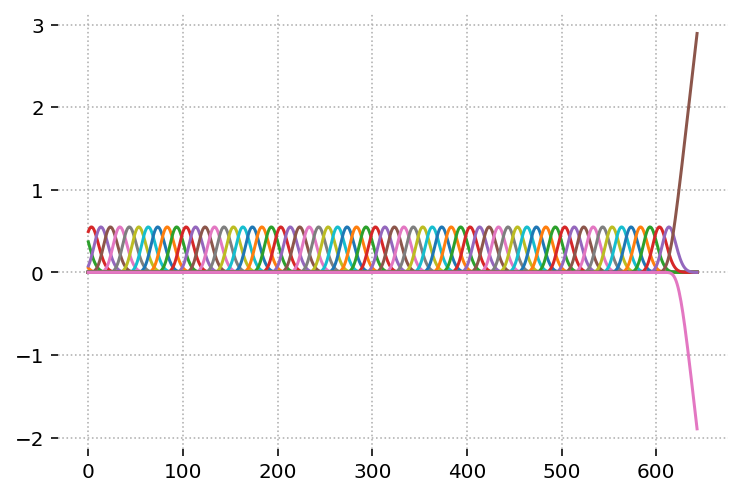

In [64]:
for i in range(B0.shape[-1]):
    plt.plot(B0[0,:,i])

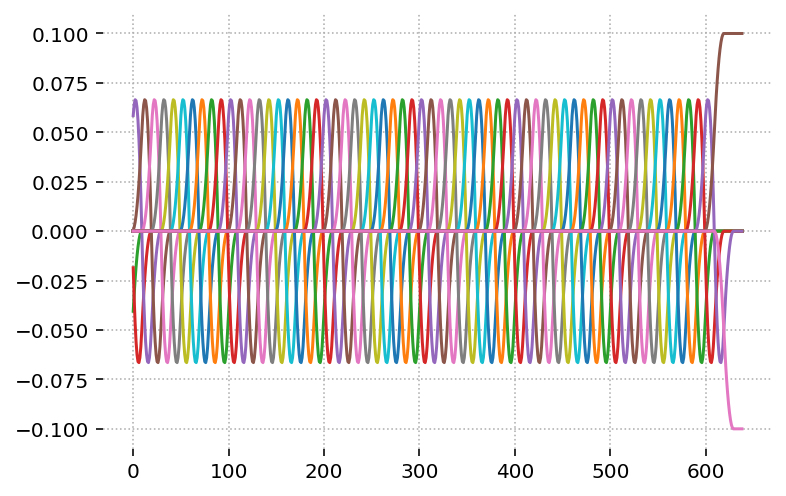

In [65]:
for i in range(B0.shape[-1]):
    plt.plot(B0[1,:-5,i])

In [66]:
np.sum(np.diff(B0[1,-30:,-1])+1 == 1)

14

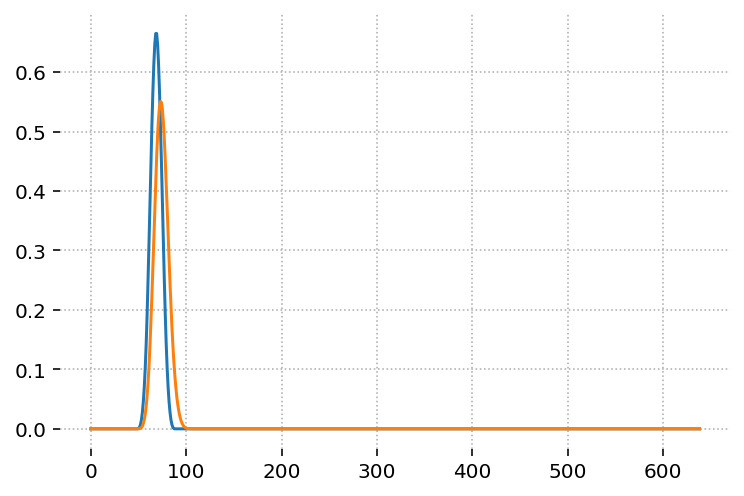

In [67]:
plt.plot(B0[1,:-5,10].cumsum())
plt.plot(B0[0,:-5,10])


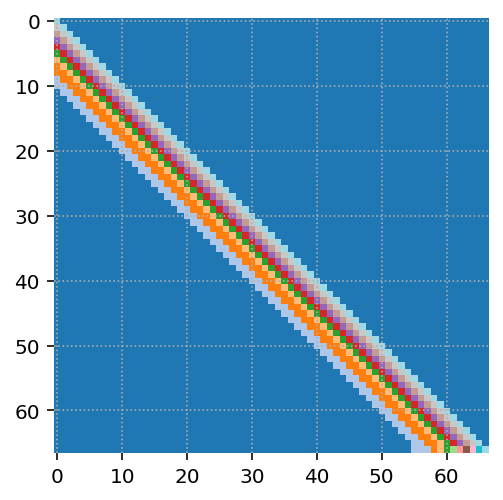

In [68]:
arma2 = np.eye(B0.shape[-1]) ## Prior covariance matrix for the splines to avoid too many wrinkles
for j in range(arma2.shape[0]-1):
    arma2[j+1,j] = -0.75
arma2[-1,-2] = -.9
arma2 = np.linalg.inv(arma2)
plt.imshow(arma2)

### Case and genome data
Prepare as arrays and add Germany as a whole

In [69]:
seq_index = np.array([list(cases_land.columns).index(i) for i in genomes.index.levels[1]])

In [70]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, alias

In [71]:
from numpyro.infer import Trace_ELBO

In [78]:
GG = np.concatenate([G, G.sum(0, keepdims=True)], axis=0) # Add Germany as a whole
CC = np.concatenate([C, C.sum(0, keepdims=True)], axis=0)
#CC[-1, -2:] = np.nan #cases_land.columns.to_list().index(np.datetime64("2022-10-03"))

In [79]:
CC[-1, -14:]

array([ 51896.        ,  48318.        ,  48252.        ,  19936.        ,
        16211.        ,  78016.        ,  94600.        ,  86975.81086925,
        74016.52978581,  71124.52693961,  23420.22278394,  14106.42875875,
        16296.1316674 , 120151.072949  ])

In [80]:
CC[2,cases_land.columns == np.datetime64("2022-03-08")] = np.nan # int women's day in Berlin..
#GG[-1, genomes.index.levels[1] <= "2022-07-15", merged_lineages_alias.index("BA.2.75")] = 0
GG[:, genomes.index.levels[1] < "2022-02-01", merged_lineages_alias.index("BA.5")] = 0 # Some erroneous BA.5
GG[:, genomes.index.levels[1] >= "2021-11-01", merged_lineages_alias.index("B")] = 0 # Issues with spurious B lineages later on
GG[:, genomes.index.levels[1] >= "2021-11-01", merged_lineages_alias.index("B.1.1.7")] = 0 # Issues with spurious B lineages later on
GG[:, genomes.index.levels[1] >= "2021-11-01", merged_lineages_alias.index("B.1.351")] = 0 # Issues with spurious B lineages later on
GG[:, (genomes.index.levels[1] < "2021-11-01").reshape(-1,1) * np.array([x.startswith("B.1.1.529") for x in merged_lineages]).reshape(1,-1)] = 0
GG[:, (genomes.index.levels[1] < "2021-04-01").reshape(-1,1) * np.array([x.startswith("B.1.617.2") for x in merged_lineages]).reshape(1,-1)] = 0

In [81]:
GG[:, genomes.index.levels[1] <= "2021-04-01"][:,:,[x.startswith("B.1.617.2") for x in merged_lineages]].sum()

0.0

In [82]:
x = (GG[-1].cumsum(0)>0).argmax(0)
dict(zip(merged_lineages, x))

{'A': 5,
 'B.1.1.7': 1,
 'B.1.1.28.1': 33,
 'B.1.1.318': 20,
 'B.1.1.529': 348,
 'B.1.1.529.1': 326,
 'B.1.1.529.1.1': 320,
 'B.1.1.529.2': 336,
 'B.1.1.529.2.12.1': 458,
 'B.1.1.529.2.75': 518,
 'B.1.1.529.2.75.1': 541,
 'B.1.1.529.2.75.2': 579,
 'B.1.1.529.4': 415,
 'B.1.1.529.4.6': 489,
 'B.1.1.529.5': 429,
 'B.1.1.529.5.2': 384,
 'B.1.1.529.5.2.1.7': 528,
 'B.1.1.529.5.2.1.11': 543,
 'B.1.1.529.5.2.1.13': 572,
 'B.1.1.529.5.2.1.14': 553,
 'B.1.1.529.5.3.1.1.1.1.1': 599,
 'B.1.1.529.5.3.1.1.1.1.1.1': 600,
 'B.1.351': 4,
 'B.1.525': 17,
 'B.1.617.2': 94,
 'B.1.617.2.4.2': 186,
 'B.1.617.2.36.1': 276,
 'B.1.617.2.43': 170,
 'B.1.617.2.46.6': 189,
 'B.1.621': 98,
 'B': 0}

### Model
Multi-lineage model with variable growth rates (random effect) across states

In [83]:
model = MultiLineageTimeShift(
    CC[[-1]],
    GG[[-1]],    
    seq_index,
    np.concatenate([capita.values, capita.values.sum().reshape(1)])[[-1]],
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    #b_scale=0.01,
    b0_scale=0.3,
    #c_scale=30,
    c0_scale=5,
    c0_loc=-10,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.001,#.001,
    alpha1=1000., 
    week=True,
    fit_logits=True,#True,
    ancestor_matrix=A,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=100), 'num_epochs':2000, 'lr':0.03, 'lrd': 0.5 ** (1/2000), 'num_samples': 100, 'log_freq':200}

)

In [84]:
model.fit(num_epochs=200)

SVI step 0 / 200 | 0 %


(0.0, 1000000.0)

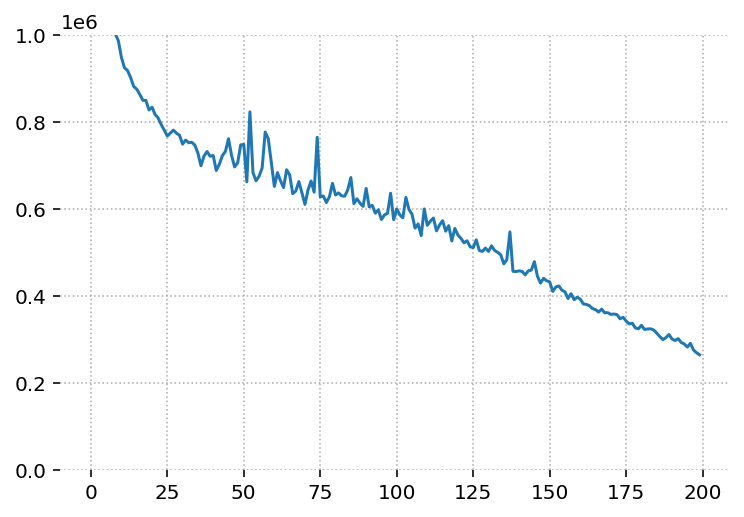

In [85]:
plt.plot(model.loss)
plt.ylim((0,1e6))
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [86]:
model.fit(num_epochs=400)

SVI step 0 / 400 | 0 %
SVI step 200 / 400 | 50 %


Text(0, 0.5, 'ELBO')

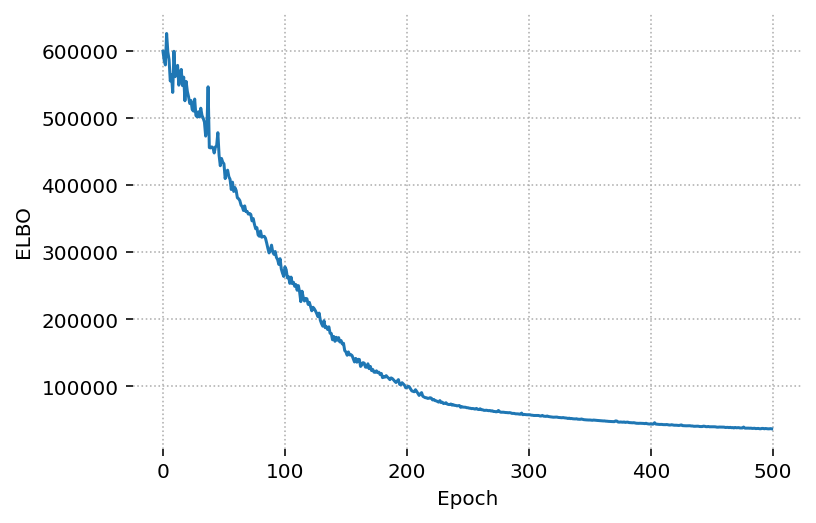

In [89]:
plt.plot(model.loss[100:])
#plt.ylim((0,1e6))
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [94]:
model.fit(num_epochs=2000)

SVI step 0 / 2,000 | 0 %
SVI step 200 / 2,000 | 10 %
SVI step 400 / 2,000 | 20 %
SVI step 600 / 2,000 | 30 %
SVI step 800 / 2,000 | 40 %
SVI step 1,000 / 2,000 | 50 %
SVI step 1,200 / 2,000 | 60 %
SVI step 1,400 / 2,000 | 70 %
SVI step 1,600 / 2,000 | 80 %
SVI step 1,800 / 2,000 | 90 %


Text(0, 0.5, 'ELBO')

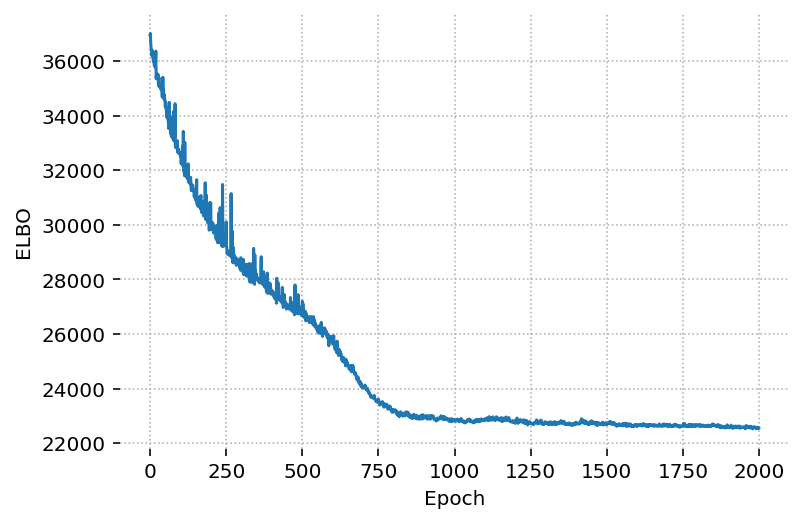

In [95]:
plt.plot(model.loss[-2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')
#plt.ylim((model.loss[2000],model.loss[1200]))

In [96]:
lineage_colors = {'B.1.1.529':'C7',
                 'BA.1': 'rebeccapurple',#'mistyrose', #
                 'BA.1.1': 'C4',#"lavender", #
                 'BA.2':"C1", 
                 'BA.2.12.1':"C6",
                 'BA.2.75':"orangered",
                  'BA.2.75.1':"salmon",
                  'BA.2.75.2':"C3",
                 'BA.4':"C8",
                 'BA.4.6': 'peru',
                 'BA.5':"C9",
                  'BA.5.2': 'darkcyan',
                  "BF.7":"limegreen",
                  'BF.11':"C2",
                  'BF.13':"yellowgreen",
                  'BF.14':'green',
                   'BQ.1':'aquamarine',
                  'BQ.1.1':'mediumspringgreen',
                 #'Other':"C7",
                 'B.1.617.2': 'C0',
                 'AY.4.2': 'lightblue',
                  'AY.36.1': 'steelblue',
                  'AY.43': 'skyblue',
                  'AY.46.6': 'lightsteelblue',
                  'A': 'lightgrey',
                  'B': 'lightgrey',
                  'B.1.1.7': 'navy' ,
                  'B.1.351': 'black',
                  'P.1' : 'slategrey',
                  'B.1.525':'C7',
                  'B.1.1.318': 'grey',
                  'B.1.621':'grey'
                 } #"aliceblue"}

In [97]:
merged_lineages_alias

['A',
 'B.1.1.7',
 'P.1',
 'B.1.1.318',
 'B.1.1.529',
 'BA.1',
 'BA.1.1',
 'BA.2',
 'BA.2.12.1',
 'BA.2.75',
 'BA.2.75.1',
 'BA.2.75.2',
 'BA.4',
 'BA.4.6',
 'BA.5',
 'BA.5.2',
 'BF.7',
 'BF.11',
 'BF.13',
 'BF.14',
 'BQ.1',
 'BQ.1.1',
 'B.1.351',
 'B.1.525',
 'B.1.617.2',
 'AY.4.2',
 'AY.36.1',
 'AY.43',
 'AY.46.6',
 'B.1.621',
 'B']

In [98]:
merged_lineages_alias = [alias(x) for x in merged_lineages]

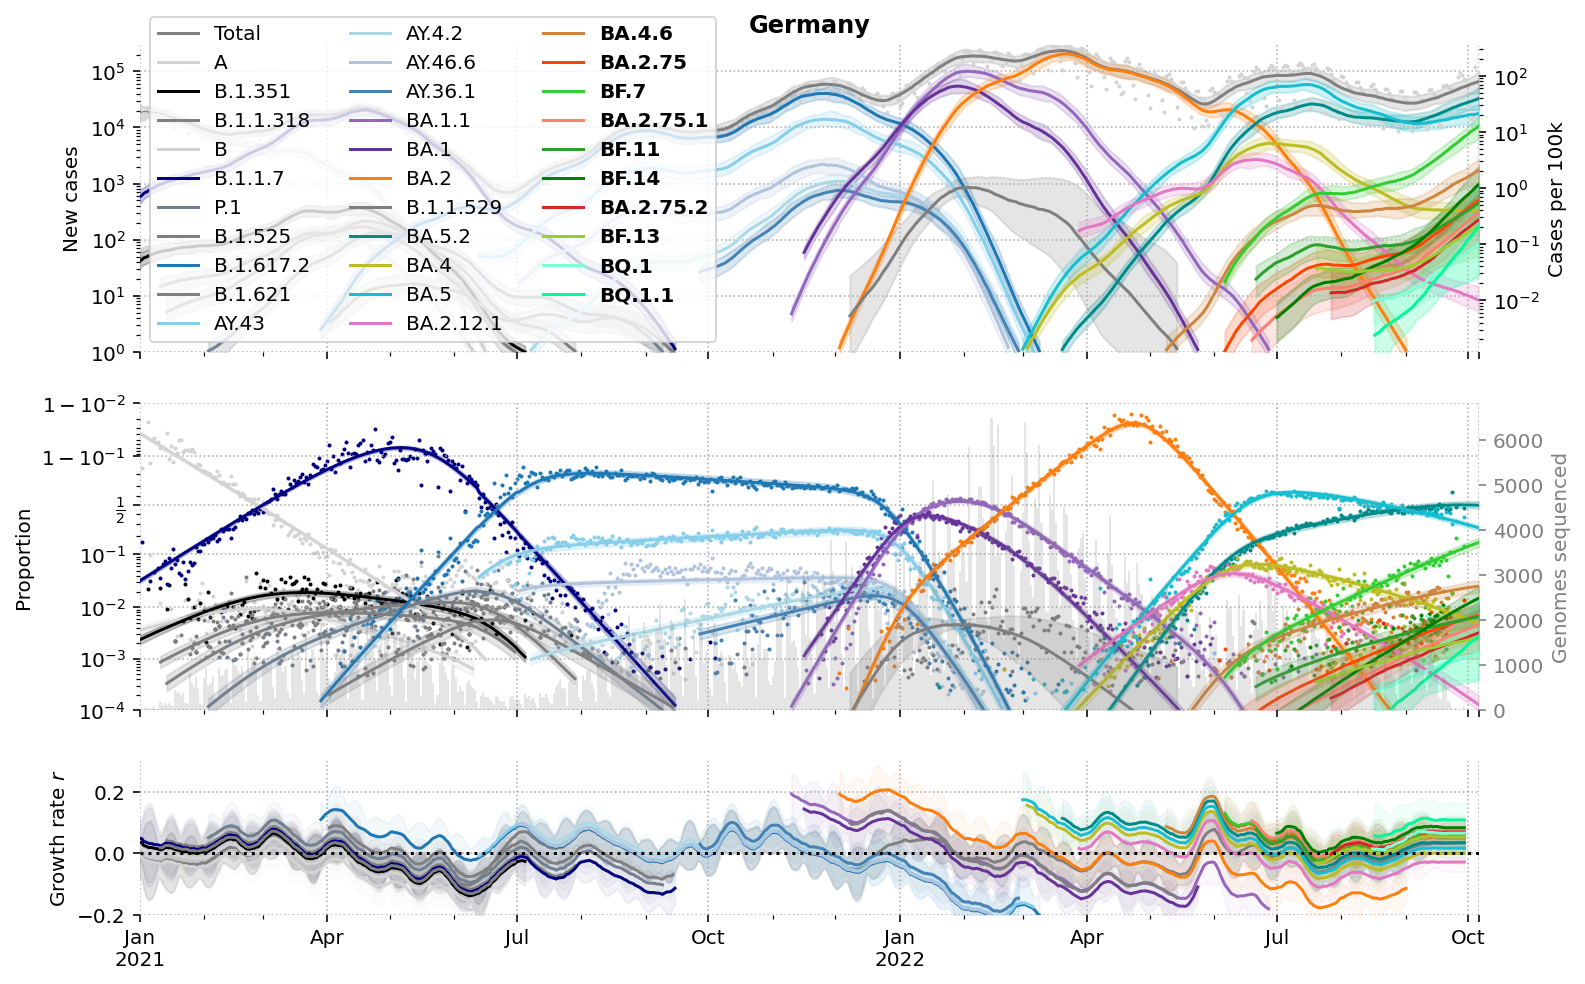

In [99]:
#from genomicsurveillance.plots.england import plot_lad, 
plt.rcParams['font.sans-serif'] = ["DejaVu Sans"]
from matplotlib import gridspec
from genomicsurveillance.plots.england import plot_median_and_ci
#from matplotlib import rc
#rc('text', usetex=False)
x = (GG[-1].cumsum(0)>0).argmax(0)
o = np.argsort(x + np.argsort(merged_lineages))
for i,r in [(-1, "Germany")]:#enumerate(cases_land.index.to_list() + ["Germany"]):
    w = o#np.where(GG[i].sum(0) >= 3)[0]
    #w = list(set(w) - set([0,GG.shape[2]-2]))
    #w = [w[-1]] + w[:-1]
    #plt.set_cmap("tab20")
    col = [lineage_colors[x] for x in merged_lineages_alias]
    plot_lad(model, i, CC, GG, seq_index, start_date=start_date, show_start_date=start_date,
        lin = w,
        labels = np.array(merged_lineages_alias)[w], #[x if not x in ["BA.2.75", "BA.4.6","BA.5.2.1.7","BA.5.2.1.11"] else r"$\bf{"+x+"}$" for x in merged_lineages_alias])[w],#genomes.columns[w],
        #lin_colors=np.array(5*['C7','C3',"C4","C1", "C6","C8" ,"C9", "C7","C0"])[w],#, "C6", "C1","C8"],
        lin_colors=np.array(5*col)[w],#, "C6", "C1","C8"],
        #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
        case_color="grey",
        case_markercolor="lightgrey",
             lin_marker=".",
             lin_marker_size=2,
            figsize=(12,8),
            prop_err=False,
            show_Rt=False)

    ax=plt.gcf().get_axes()
    
    ax[0].set_title(r, size=12, weight='bold')
    ax[0].set_yscale('log')
    ax[0].set_ylim((1,None))
   
    #ax[1].grid(which='both', ls=":")
    #ax[0].legend(loc='center left')
    #ax[2].set_ylim((-0.2,0.3))
    #ax[3].grid(False)
    
    #for a in ax:
        #a.xaxis.set_major_formatter(pd.plotting._matplotlib.converter.TimeSeries_DateFormatter("D"))
        #for s in a.spines:
        #    a.spines[s].set_visible(True)
    #fig = plt.gcf()
    #plt.tight_layout()
    ax[0].set_ylim((None, np.nanmax(CC[i,:])))
    ax[1].set_yscale("logit")
    ax[1].set_ylim((1e-4,1-1e-2))
    ax[2].set_ylim((-.2,.3))
    ax[1].get_legend().remove()
    ax[2].get_legend().remove()
    #ax[2].set_xlim(("2022-06-01",None))
    #ax[0].legend("off")
    for i in range(3):
        ax[i].set_position(gridspec.GridSpec(3, 1, height_ratios=[1,1, 0.5])[i].get_position(plt.gcf()))
    #ax[2].legend(loc="upper left")
    ax[2].axhline(0, color='k', ls=":")
    leg = ax[0].legend(loc="lower left", ncol=3)
    for l in leg.get_texts():
        if re.match("|".join(["BA.2.75", "BA.4.6","BF","BQ"]),l.get_text()):
            l.set_weight('bold')
    #plt.gcf().set_size_inches(12,12)

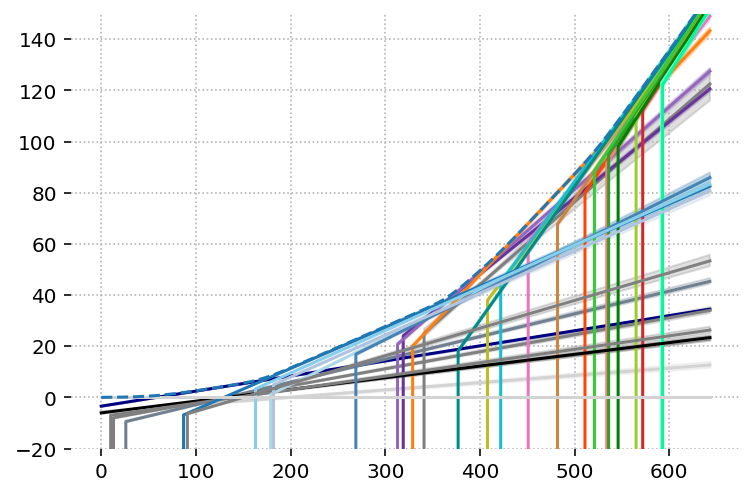

In [100]:
l = model.get_logits(ltla=-1).squeeze()
#l -= logsumexp(l.mean(0),-1)[...,np.newaxis]
#m = 0.5 * (((r-r[0])/x)[:-1].mean()) * np.arange(l.shape[1])**2 + r[1]*np.arange(l.shape[1]) - 15#np.max(np.mean(l,0),-1)
for i in range(l.shape[-1]):
    plt.plot(np.median(l[...,i],0), c=lineage_colors[merged_lineages_alias[i]])
    plt.fill_between(x=np.arange(l.shape[1]), y1=np.quantile(l[...,i],0.05, 0), y2=np.quantile(l[...,i],0.95, 0), color=lineage_colors[merged_lineages_alias[i]], alpha=0.25)
plt.ylim((-20,150))
#l.shape
#plt.plot(seq_index, 0.5 * 0.0008 * seq_index**2)

from scipy.special import logsumexp
plt.plot(logsumexp(l.mean(0).squeeze(), -1), ls="--")


#plt.plot(np.max(np.mean(l,0),-1))

In [101]:
lse = logsumexp(l.mean(0).squeeze(), -1)
t0 = 100
y =lse[-t0:] - (lse[-t0]-lse[-t0-1])*np.arange(t0) - lse[-t0]
#plt.plot(np.diff(y))
#plt.plot(l.mean(0).squeeze().max(-1))

In [102]:
b = np.array(model.posterior['b1'])
b[b==0] = np.nan
b[...,-1]= 0
r = pd.DataFrame((b - b[...,[1]]).mean((0,2)), columns=merged_lineages_alias, index=["Germany"])# cases_land.index.to_list() + ["Germany"])

In [103]:
r

A  B.1.1.7       P.1  B.1.1.318  B.1.1.529      BA.1  \
Germany -0.030258      0.0  0.029999   0.007863   0.263241  0.239181   

           BA.1.1      BA.2  BA.2.12.1   BA.2.75  ...    BQ.1.1   B.1.351  \
Germany  0.264509  0.333508   0.400051  0.493907  ...  0.535263 -0.013126   

          B.1.525  B.1.617.2    AY.4.2   AY.36.1     AY.43  AY.46.6   B.1.621  \
Germany -0.006269   0.101891  0.122589  0.126187  0.107491  0.10533  0.049275   

                B  
Germany -0.058917  

[1 rows x 31 columns]

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 [Text(1, 0, 'A'),
  Text(2, 0, 'B.1.1.7'),
  Text(3, 0, 'P.1'),
  Text(4, 0, 'B.1.1.318'),
  Text(5, 0, 'B.1.1.529'),
  Text(6, 0, 'BA.1'),
  Text(7, 0, 'BA.1.1'),
  Text(8, 0, 'BA.2'),
  Text(9, 0, 'BA.2.12.1'),
  Text(10, 0, 'BA.2.75'),
  Text(11, 0, 'BA.2.75.1'),
  Text(12, 0, 'BA.2.75.2'),
  Text(13, 0, 'BA.4'),
  Text(14, 0, 'BA.4.6'),
  Text(15, 0, 'BA.5'),
  Text(16, 0, 'BA.5.2'),
  Text(17, 0, 'BF.7'),
  Text(18, 0, 'BF.11'),
  Text(19, 0, 'BF.13'),
  Text(20, 0, 'BF.14'),
  Text(21, 0, 'BQ.1'),
  Text(22, 0, 'BQ.1.1'),
  Text(23, 0, 'B.1.351'),
  Text(24, 0, 'B.1.525'),
  Text(25, 0, 'B.1.617.2'),
  Text(26, 0, 'AY.4.2'),
  Text(27, 0, 'AY.36.1'),
  Text(28, 0, 'AY.43'),
  Text(29, 0, 'AY.46.6'),
  Text(30, 0, 'B.1.621'),
  Text(31, 0, 'B')])

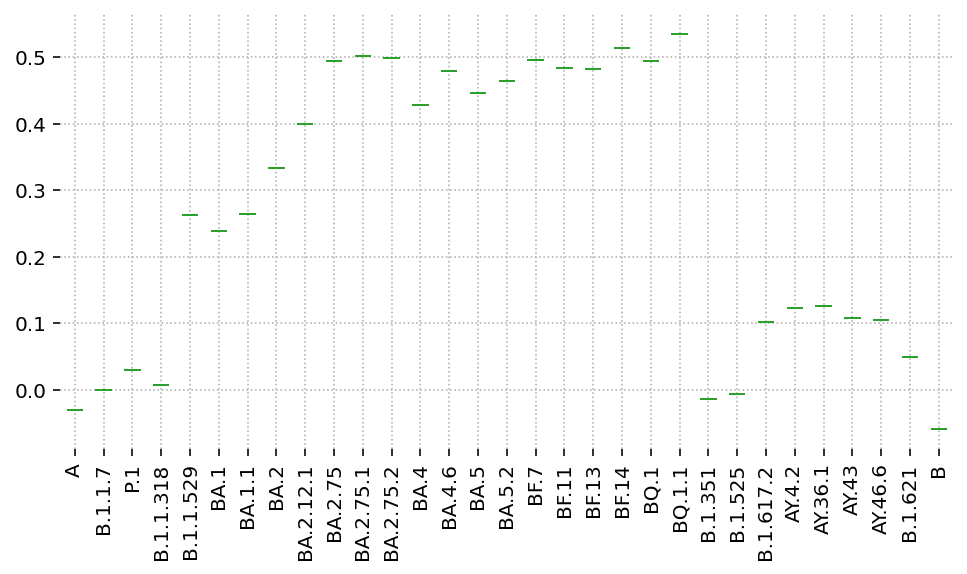

In [104]:
#r[r==0] = np.nan
plt.figure(figsize=(8,4))
r.boxplot(figsize=(8,4))
plt.xticks(rotation=90)
#r.mean(0).plot(ls="", marker=".")


In [105]:
import re

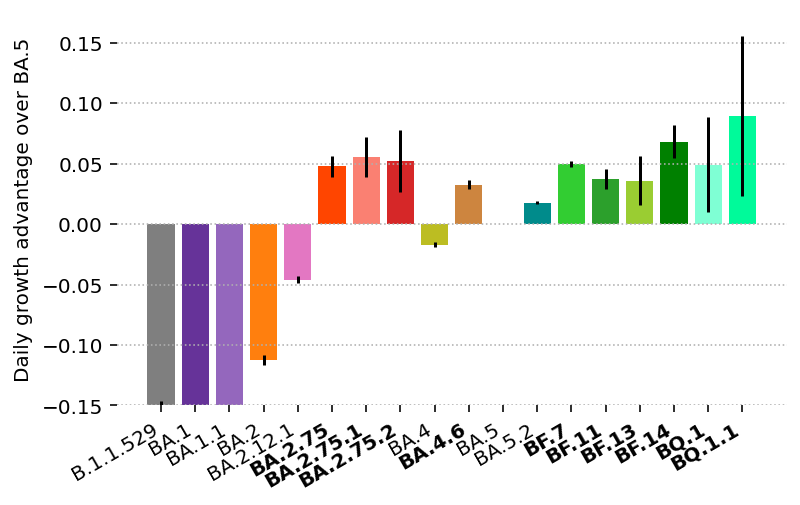

[Text(0, 0, 'B.1.1.529'), Text(1, 0, 'BA.1'), Text(2, 0, 'BA.1.1'), Text(3, 0, 'BA.2'), Text(4, 0, 'BA.2.12.1'), Text(5, 0, 'BA.2.75'), Text(6, 0, 'BA.2.75.1'), Text(7, 0, 'BA.2.75.2'), Text(8, 0, 'BA.4'), Text(9, 0, 'BA.4.6'), Text(10, 0, 'BA.5'), Text(11, 0, 'BA.5.2'), Text(12, 0, 'BF.7'), Text(13, 0, 'BF.11'), Text(14, 0, 'BF.13'), Text(15, 0, 'BF.14'), Text(16, 0, 'BQ.1'), Text(17, 0, 'BQ.1.1')]


In [106]:
baseline = "BA.5"
s = pd.DataFrame((b - b[...,[merged_lineages_alias.index(baseline)]]).mean((2))[:,-1], columns=merged_lineages_alias)[[x for x in merged_lineages_alias if alias(x, anti_alias=True).startswith("B.1.1.529")]]
#s.boxplot()
plt.figure(figsize=(6,4))
plt.bar(s.columns, s.iloc[:-1,:].mean(), yerr=2*s.std(), color=[lineage_colors[x] for x in s.columns])
#plt.ylim((-0.15,0.2))
plt.ylim((-0.15,None))
#plt.draw()
#lt.xticks(rotation=45)
plt.ylabel(f"Daily growth advantage over {baseline}")
plt.grid(False)
plt.grid(axis="y")
plt.gcf().autofmt_xdate()
plt.draw()
xl = plt.gca().get_xticklabels()
for l in xl:
    if re.match("|".join(["BA.2.75", "BA.4.6","BF","BQ.1"]),l.get_text()):
        l.set_weight('bold')
plt.show()
print(xl)

In [107]:
q=(0.025,0.5,0.975)
pd.DataFrame(np.quantile(model.get_probabilities()[:,0,-1:,:], q, 0).squeeze(), index=np.array(q), columns=merged_lineages_alias).T

0.025         0.500         0.975
A          0.000000e+00  0.000000e+00  0.000000e+00
B.1.1.7    0.000000e+00  0.000000e+00  0.000000e+00
P.1        0.000000e+00  0.000000e+00  0.000000e+00
B.1.1.318  0.000000e+00  0.000000e+00  0.000000e+00
B.1.1.529  2.462883e-20  4.191007e-16  1.646167e-12
BA.1       3.538676e-17  6.356995e-17  1.081949e-16
BA.1.1     3.801073e-14  6.106145e-14  1.103488e-13
BA.2       2.921463e-07  4.534756e-07  6.952423e-07
BA.2.12.1  9.682038e-05  1.263426e-04  1.892106e-04
BA.2.75    4.656333e-03  6.966868e-03  1.247044e-02
BA.2.75.1  2.311145e-03  4.575191e-03  9.811618e-03
BA.2.75.2  1.347826e-03  3.225865e-03  8.749642e-03
BA.4       3.892617e-03  4.773878e-03  5.812322e-03
BA.4.6     1.928076e-02  2.548644e-02  3.292586e-02
BA.5       2.408823e-01  2.654309e-01  2.867123e-01
BA.5.2     4.643806e-01  4.983669e-01  5.409563e-01
BF.7       1.337992e-01  1.582206e-01  1.882909e-01
BF.11      4.449704e-03  6.600673e-03  1.095522e-02
BF.13      1.014677e-03  2.507636e-03  6.151616e-03
BF.14      8.643024e-03  1.507942e-02  2.501012e-02
BQ.1       3.980262e-04  1.299779e-03  5.162727e-03
BQ.1.1     3.655140e-04  2.733190e-03  1.511788e-02
B.1.351    0.000000e+00  0.000000e+00  0.000000e+00
B.1.525    0.000000e+00  0.000000e+00  0.000000e+00
B.1.617.2  6.141939e-34  2.033214e-33  4.938365e-33
AY.4.2     1.038143e-32  3.360781e-32  1.308815e-31
AY.36.1    2.125727e-32  6.821607e-32  1.987990e-31
AY.43      1.229447e-33  3.848040e-33  1.137367e-32
AY.46.6    8.050235e-35  3.186580e-34  1.032328e-33
B.1.621    0.000000e+00  0.000000e+00  4.939577e-45
B          0.000000e+00  0.000000e+00  0.000000e+00

In [108]:
λ = np.median(model.get_lambda_lineage(),0) / model.population[:,np.newaxis, np.newaxis]

In [109]:
λ.shape

(1, 644, 31)

In [110]:
from genomicsurveillance.misc import get_transmissibility

In [111]:
GG.shape

(17, 634, 31)

In [112]:
d = model.posterior['bc0'].mean(0).squeeze()[:GG.shape[-1]-1]

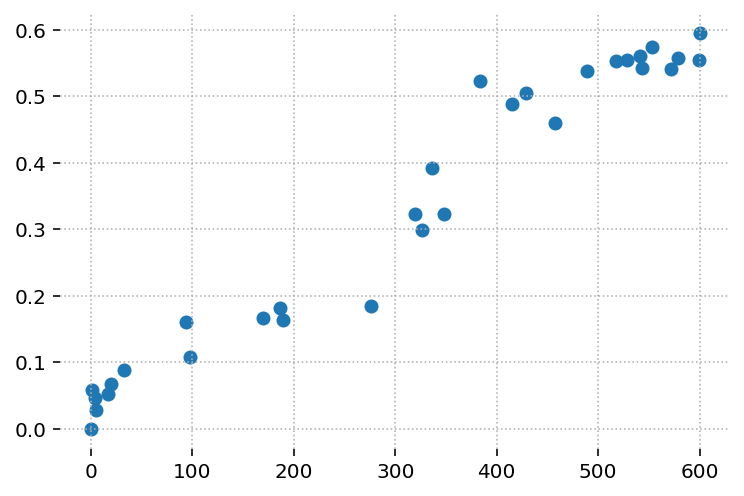

In [113]:
x = (GG[-1].cumsum(0)>0).argmax(0)
r = b.squeeze().mean(0)
plt.scatter(x, r)

In [114]:
x = (GG[-1].cumsum(0)>0).argmax(0)
y = (-GG[-1]).cumsum(0).argmin(0)
dict(zip(merged_lineages_alias, genomes.index.levels[1][y]))

{'A': Timestamp('2021-06-21 00:00:00'),
 'B.1.1.7': Timestamp('2021-10-04 00:00:00'),
 'P.1': Timestamp('2021-10-22 00:00:00'),
 'B.1.1.318': Timestamp('2022-03-24 00:00:00'),
 'B.1.1.529': Timestamp('2022-06-30 00:00:00'),
 'BA.1': Timestamp('2022-09-09 00:00:00'),
 'BA.1.1': Timestamp('2022-07-21 00:00:00'),
 'BA.2': Timestamp('2022-09-29 00:00:00'),
 'BA.2.12.1': Timestamp('2022-09-19 00:00:00'),
 'BA.2.75': Timestamp('2022-09-29 00:00:00'),
 'BA.2.75.1': Timestamp('2022-09-21 00:00:00'),
 'BA.2.75.2': Timestamp('2022-09-20 00:00:00'),
 'BA.4': Timestamp('2022-09-22 00:00:00'),
 'BA.4.6': Timestamp('2022-09-23 00:00:00'),
 'BA.5': Timestamp('2022-09-29 00:00:00'),
 'BA.5.2': Timestamp('2022-09-29 00:00:00'),
 'BF.7': Timestamp('2022-09-29 00:00:00'),
 'BF.11': Timestamp('2022-09-20 00:00:00'),
 'BF.13': Timestamp('2022-09-21 00:00:00'),
 'BF.14': Timestamp('2022-09-20 00:00:00'),
 'BQ.1': Timestamp('2022-09-15 00:00:00'),
 'BQ.1.1': Timestamp('2022-09-19 00:00:00'),
 'B.1.351': Time

In [115]:
ll = model.get_logits()
ll = np.concatenate([ll, ll[:,:,[-1],:] + np.arange(1,90).reshape((1,1,-1,1)) * model.posterior['b1']], axis=2)

In [116]:
from scipy.special import softmax
pp = softmax(ll, axis=-1)

In [117]:
f = np.einsum("...l,...l", pp, b).squeeze()

In [118]:
r = b.squeeze()
from adjustText import adjust_text

In [119]:
r.shape

(100, 31)

In [120]:
f.shape

(100, 733)

In [121]:
r0 = model.get_growth_rate().squeeze()

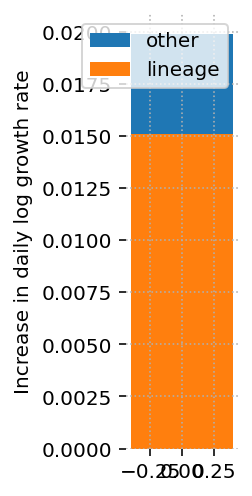

In [122]:
plt.figure(figsize=(1,4))
plt.bar(x=0,height=(r0[:,-1]-r0[:,-29]).mean(0), bottom=(f[:,-1]-f[:,-29]).mean(0), label='other') 
plt.bar(x=0 , height=(f[:,-1]-f[:,-29]).mean(0), label='lineage')
plt.ylabel("Increase in daily log growth rate")
plt.legend()

In [123]:
 cases_land.columns

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2022-09-25', '2022-09-26', '2022-09-27', '2022-09-28',
               '2022-09-29', '2022-09-30', '2022-10-01', '2022-10-02',
               '2022-10-03', '2022-10-04'],
              dtype='datetime64[ns]', name='Refdatum', length=642, freq=None)

In [124]:
f.shape

(100, 733)

In [125]:
import matplotlib.pyplot as plt

In [126]:
importlib.reload(plt)

<module 'matplotlib.pyplot' from '/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/matplotlib/pyplot.py'>

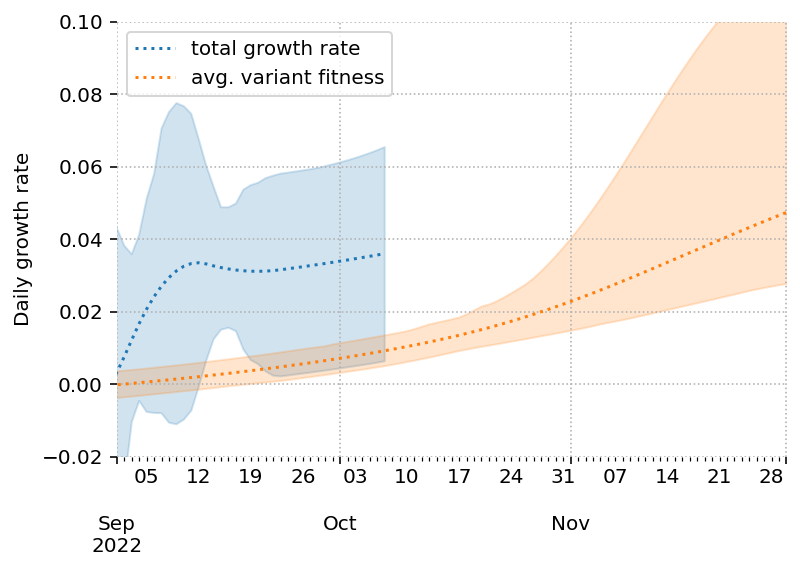

In [127]:
#plt.figure(figsize=(1,4))
pd.Series(np.nan, index=pd.date_range("2022-01-01","2022-07-01")).plot(label="", figsize=(6,4)) 
plt.plot(cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]'),r0.mean(0), label="total growth rate", c="C0", ls=":") 
plt.fill_between(cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]'), np.quantile(r0,0.05,0),np.quantile(r0,0.95,0), alpha=0.2, color="C0") 
t0 = cases_land.columns.to_list().index(np.datetime64("2022-09-01"))
plt.plot(cases_land.columns[1] + np.arange(f.shape[1]).astype('timedelta64[D]'),f.mean(0)-f.mean(0)[t0], label="avg. variant fitness", ls=":") 
#plt.bar(x=0 , height=(f[:,-1]-f[:,-29]).mean(0), label='lineage')
plt.fill_between(cases_land.columns[1] + np.arange(f.shape[1]).astype('timedelta64[D]'),np.quantile(f-f.mean(0)[t0],0.05,0),np.quantile(f-f.mean(0)[t0],0.95,0), alpha=0.2, color="C1") 
plt.xlim(("2022-09-01","2022-11-30"))
plt.ylim((-0.02,0.1))
plt.ylabel("Daily growth rate")
plt.legend(loc='upper left')

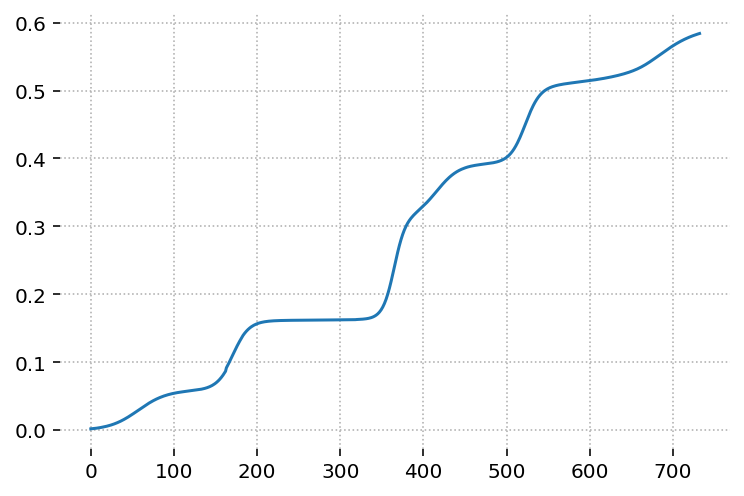

In [128]:
plt.plot(f.mean(0))

In [129]:
r.shape

(100, 31)

467

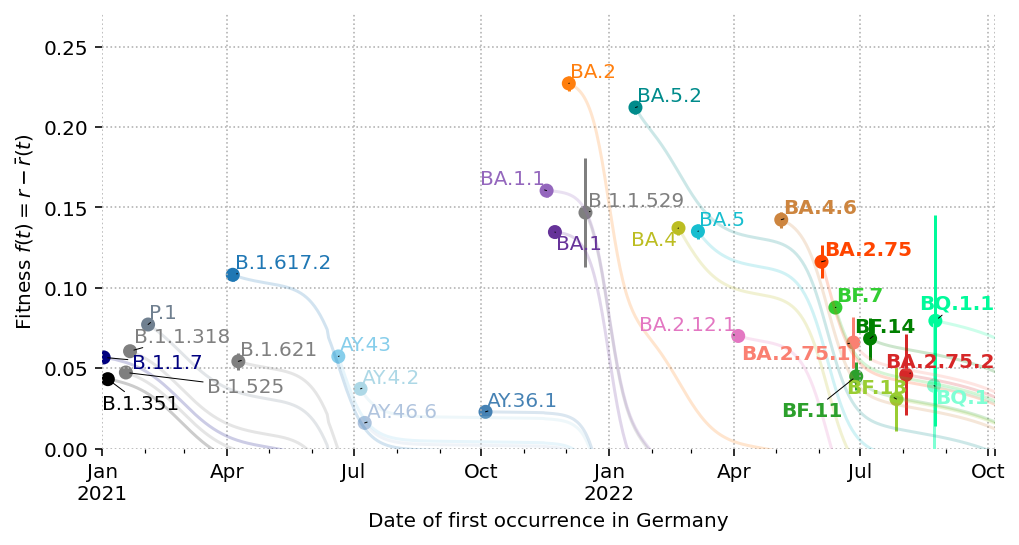

In [130]:
x = (GG[-1].cumsum(0)>0).argmax(0)
pd.Series(np.nan, index=np.arange("2021-01-01",np.datetime64('today'))).plot()
plt.xlim(("2021-01-01",np.datetime64('today')))
df = pd.DataFrame({"Growth advantage to Delta":r.mean(), "Relative growth advantage f":(r-f[:,x]).mean(0), "Lineage":merged_lineages_alias},index=cases_land.columns[x]).iloc[1:-1,:]
df["Relative growth advantage f"].plot(ls="", figsize=(8,4))
plt.errorbar(df.index, df["Relative growth advantage f"], yerr=2*(r-f[:,x]).std(0)[1:-1], ls="", c=[lineage_colors[x] for x in df.Lineage])
plt.scatter(df.index, df["Relative growth advantage f"], marker='o', c=[lineage_colors[x] for x in df.Lineage])
for i in range(df.shape[0]):
    j = merged_lineages_alias.index(df.Lineage[i])
    plt.plot(cases_land.columns[x[j]] + np.arange(f.shape[1]-x[j]).astype("timedelta64[D]"), (r[:,[j]]-f[:,x[j]:]).mean(0), c=lineage_colors[df.Lineage[i]], ls="-", alpha=0.2)
text=[]
for x,y,s in zip(df.index.tolist(), df["Relative growth advantage f"],df.Lineage.tolist()):
    text.append(plt.text(x,y,s, ha='left', va='center', color=lineage_colors[s]))
plt.xlabel("Date of first occurrence in Germany")
#plt.xlabel('')
plt.ylabel("Fitness $f(t) = r-\\bar{r}(t)$")
for l in text:
    if re.match("|".join(["BA.2.75", "BA.4.6","BF","BQ"]),l.get_text()):
        l.set_weight('bold')
plt.ylim((0.00,None))
#secax = plt.gca().secondary_yaxis('right', functions=(lambda x: np.log(2)/x, lambda x: 1/np.log(2)/x))
#secax.set_ylabel('Doubling time')
#secax.set_yscale('log')
#secax.set_yticks(np.concatenate([np.arange(50,10,-10),np.arange(10,1,-1)]))
#secax.spines['right'].set_visible(False)
adjust_text(text, 
                #add_objects=line, 
                #expand_objects = (1,1),
                #force_objects =  (0, 0.2),
                #only_move=dict(objects='y', text='y', points='y'),
                arrowprops=dict(arrowstyle="-", color='k', lw=0.5), )

In [131]:
np.mean(model.posterior['c1'].squeeze(),0)

array([ -5.661529 ,  -3.7529993,  -9.610708 ,  -8.020114 ,  -9.1301565,
        -6.6504655,  -8.937938 , -12.222645 ,  -5.0416794,  -9.348068 ,
        -7.229313 ,  -4.6469436, -12.104667 , -10.264464 ,  -9.982358 ,
       -22.524181 ,  -4.9635887,  -4.619823 ,  -3.8913724,  -6.0043097,
        -4.610657 ,  -5.971992 ,  -6.1601896,  -7.0445857,  -8.791937 ,
        -7.249763 ,  -5.717196 ,  -3.2658608,  -3.8414762,  -8.50888  ,
         0.       ], dtype=float32)

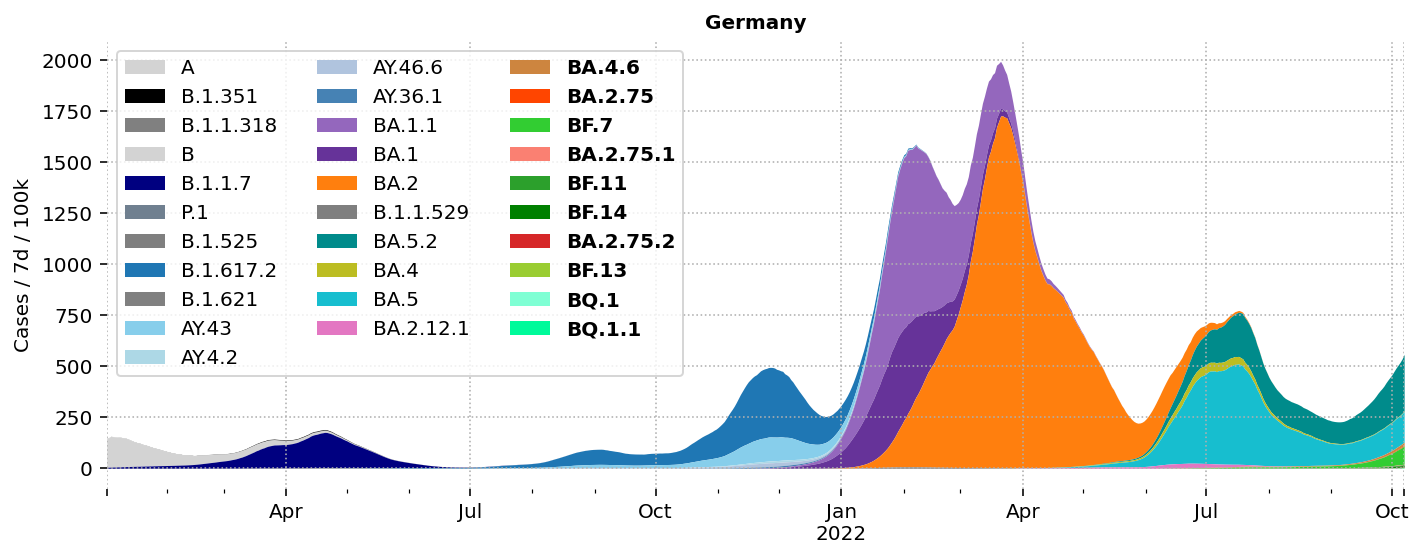

In [132]:
fig, ax = plt.subplots(1,1, figsize=(10,4), sharex=True, sharey=True)
ax = [ax]
#ax = ax.flatten()
#col = ['C7','C3',"C4","C1", "C6","C5","C8" ,"C9", "C7","C0"]
#labels =[alias(x) for x in merged_lineages]
col = lineage_colors #dict(zip(labels, col))
for i,r in enumerate(["Germany"]):
    y = pd.DataFrame(λ[i,:,:], columns=merged_lineages_alias, index=cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]')) #cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000 #* 700
    #y = y.drop(columns=["B.1.1.529","Other"])
    y = y.iloc[:,o].iloc[:,::-1].cumsum(1)* 1000 * 700
    #y = y.iloc[:,[i-1  for i in range(y.shape[1])]].iloc[:,::-1].cumsum(1)* 1000 * 700
    #y.index.name = 'date'
    #x = prop_bl.loc[r,:,:][0].unstack()
    #z = x[0.5] * y
    y["BA.1"].plot(ax=ax[i], ls="", label="")
    #(cases_land.loc[r]/capita[r]*1000 * 700).plot(ax=ax[i], marker=".", markersize=1.3, color="k", ls="", label="")
    for j in range(y.shape[1]-1,-1,-1):
        ax[i].fill_between(y.index, y.iloc[:,j-1] if j > 0 else 0, y.iloc[:,j], color=col[y.columns[j]], alpha=1, lw=0, label=y.columns[j])
    #ax[i].fill_between(y.index, y["BA.2"], y["BA.1"], color='C3', alpha=1, lw=0, label="BA.1")
    #ax[i].fill_between(y.index, y["B.1.617.2"], y["BA.2"], color='C1', alpha=1, lw=0, label="BA.2")
    #ax[i].fill_between(y.index, y["B.1.617.2"], color='C0', alpha=.5, lw=0, label="B.1.617.2")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases / 7d / 100k")
    ax[i].grid(ls=":")
    #ax[i].set_xlim(("2021-12-01",None))
    #ax[i].set_yscale("log")
    #ax[i].set_ylim((0,100))

    for a in ax[i].spines.values():
        a.set_visible(False)
leg = ax[-1].legend(title=None, ncol=3, loc='upper left')
for l in leg.get_texts():
    if re.match("|".join(["BA.2.75", "BA.4.6","BF","BQ"]),l.get_text()):
        l.set_weight('bold')

plt.tight_layout()
#fig.savefig("plots/omi_abs_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

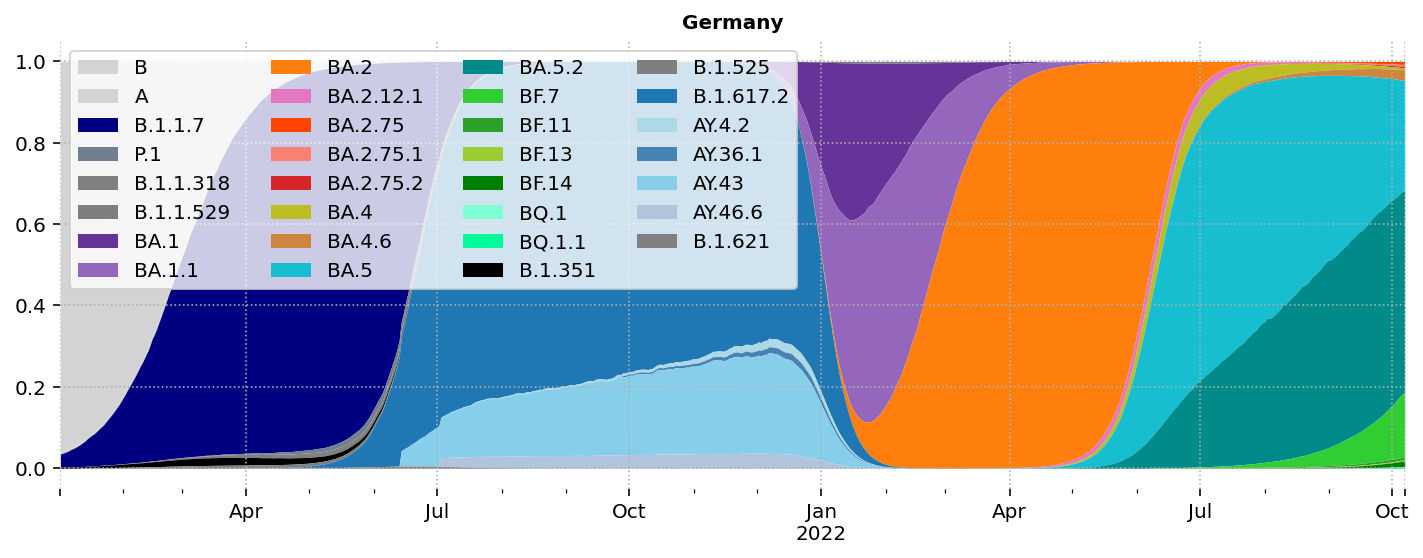

In [133]:
fig, ax = plt.subplots(1,1, figsize=(10,4), sharex=True, sharey=True)
ax = [ax]
#ax = ax.flatten()
#col = ['C7','C3',"C4","C1", "C6","C5","C8" ,"C9", "C7","C0"]
#labels =[alias(x) for x in merged_lineages]
col = lineage_colors #dict(zip(labels, col))
for i,r in enumerate(["Germany"]):
    y = pd.DataFrame(λ[i,:,:]/λ[i].sum(-1, keepdims=True), columns=merged_lineages_alias, index=cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]')) #cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000 #* 700
    #y = y.drop(columns=["B.1.1.529","Other"])
    y = y.iloc[:,[i-1  for i in range(y.shape[1])]].iloc[:,::-1].cumsum(1)#* 1000 * 700
    #y.index.name = 'date'
    #x = prop_bl.loc[r,:,:][0].unstack()
    #z = x[0.5] * y
    y["BA.1"].plot(ax=ax[i], ls="", label="")
    #(cases_land.loc[r]/capita[r]*1000 * 700).plot(ax=ax[i], marker=".", markersize=1.3, color="k", ls="", label="")
    for j in range(y.shape[1]-1,-1,-1):
        ax[i].fill_between(y.index, y.iloc[:,j-1] if j > 0 else 0, y.iloc[:,j], color=col[y.columns[j]], alpha=1, lw=0, label=y.columns[j])
    #ax[i].fill_between(y.index, y["BA.2"], y["BA.1"], color='C3', alpha=1, lw=0, label="BA.1")
    #ax[i].fill_between(y.index, y["B.1.617.2"], y["BA.2"], color='C1', alpha=1, lw=0, label="BA.2")
    #ax[i].fill_between(y.index, y["B.1.617.2"], color='C0', alpha=.5, lw=0, label="B.1.617.2")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    #ax[i].set_ylabel("Cases / 7d / 100k")
    ax[i].grid(ls=":")
    #ax[i].set_xlim(("2021-12-01",None))
    #ax[i].set_yscale("log")
    #ax[i].set_ylim((0,100))

    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(loc='upper left', title=None, ncol=4)
plt.tight_layout()
#fig.savefig("plots/omi_abs_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [134]:
j

0

In [135]:
p = model.get_probabilities().mean(0).squeeze()

In [136]:
p[-50:,merged_lineages_alias.index("BQ.1.1")]

array([8.75323822e-05, 9.27621295e-05, 9.84011567e-05, 1.04485523e-04,
       1.11055400e-04, 1.18153905e-04, 1.25829611e-04, 1.34134374e-04,
       1.43126308e-04, 1.52868306e-04, 1.63430435e-04, 1.74889850e-04,
       1.87330079e-04, 2.00845214e-04, 2.15536769e-04, 2.31518701e-04,
       2.48914759e-04, 2.67863710e-04, 2.88516283e-04, 3.11041280e-04,
       3.35623539e-04, 3.62469436e-04, 3.91804060e-04, 4.23880672e-04,
       4.58976516e-04, 4.97399713e-04, 5.39490895e-04, 5.85631293e-04,
       6.36238663e-04, 6.91778609e-04, 7.52767257e-04, 8.19780165e-04,
       8.93450284e-04, 9.74485301e-04, 1.06367108e-03, 1.16187637e-03,
       1.27007056e-03, 1.38932024e-03, 1.52082311e-03, 1.66589569e-03,
       1.82600261e-03, 2.00277893e-03, 2.19800603e-03, 2.41370243e-03,
       2.65204674e-03, 2.91547831e-03, 3.20668239e-03, 3.52861593e-03,
       3.88453295e-03, 4.27798601e-03], dtype=float32)

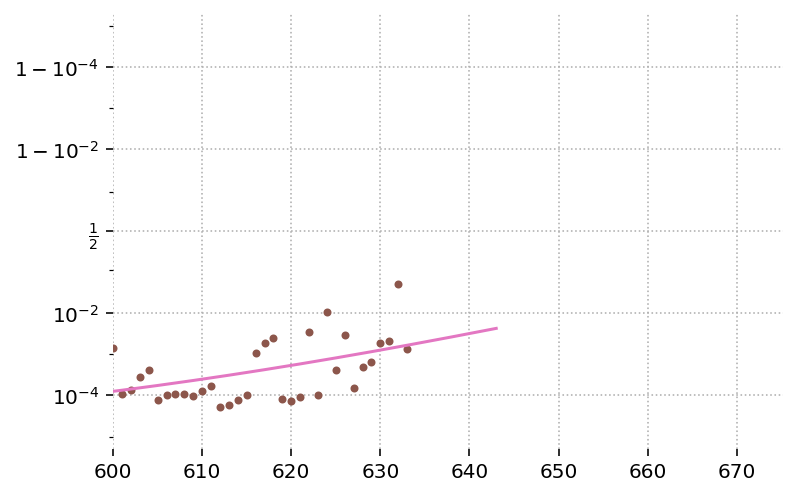

In [137]:
plt.plot(GG[-1,:,-1]/GG[-1].sum(-1))
plt.plot(GG[-1,:,0]/GG[-1].sum(-1))
plt.plot(GG[-1,:,1]/GG[-1].sum(-1))
plt.plot(GG[-1,:,-3]/GG[-1].sum(-1))
plt.plot(GG[-1,:,1]/GG[-1].sum(-1))
plt.plot(GG[-1,:,merged_lineages_alias.index("BQ.1.1")]/GG[-1].sum(-1) + 0.1/GG[-1].sum(1), ls="", marker=".")
plt.plot(p[:,merged_lineages_alias.index("BQ.1.1")])
#plt.plot(GG[-1,:,merged_lineages_alias.index("BQ.1")]/GG[-1].sum(-1), ls="", marker=".")
#plt.plot(p[:,merged_lineages_alias.index("BQ.1")])
plt.xlim((600,None))
plt.yscale('logit')

In [ ]:
p = model.get_probabilities().mean(0).squeeze()

In [338]:
p.shape

(643, 31)

In [339]:
dict(zip(merged_lineages_alias,model.posterior['c1'].squeeze().mean(0)))

{'A': -5.445433,
 'B.1.1.7': -3.3576527,
 'P.1': -9.060923,
 'B.1.1.318': -7.7027373,
 'B.1.1.529': -9.55761,
 'BA.1': -6.2502093,
 'BA.1.1': -8.37043,
 'BA.2': -11.73591,
 'BA.2.12.1': -5.0337267,
 'BA.2.75': -9.4233,
 'BA.2.75.1': -7.381408,
 'BA.2.75.2': -4.7812576,
 'BA.4': -11.801131,
 'BA.4.6': -10.211261,
 'BA.5': -9.718703,
 'BA.5.2': -21.958593,
 'BF.7': -5.0756774,
 'BF.11': -4.7726803,
 'BF.13': -4.037044,
 'BF.14': -6.1624017,
 'BQ.1': -4.7439847,
 'BQ.1.1': -6.1177354,
 'B.1.351': -5.875589,
 'B.1.525': -6.8143535,
 'B.1.617.2': -7.7366414,
 'AY.4.2': -7.250265,
 'AY.36.1': -5.6699615,
 'AY.43': -3.1938157,
 'AY.46.6': -3.871932,
 'B.1.621': -8.140902,
 'B': 0.0}

In [340]:
1/(1+np.exp(-2))

0.8807970779778823

In [341]:
c = model.posterior['c1'].mean(0)
b = model.posterior['b1'].mean(0)
c.shape

(1, 1, 31)

In [342]:
b.shape

(1, 1, 31)

In [343]:
t,g = model.clock()

In [344]:
l0 = t * b + g + c

(-20.0, 100.0)

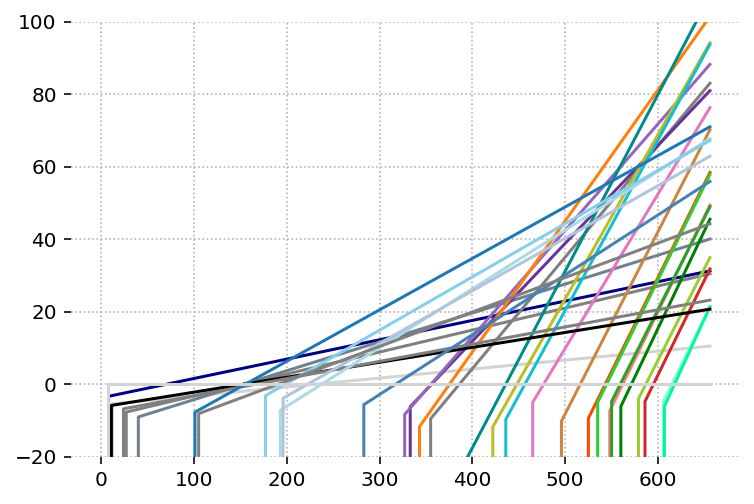

In [345]:
for i in range(l0.shape[-1]):
    plt.plot(l0[0,...,i], c=lineage_colors[merged_lineages_alias[i]])
plt.ylim((-20,100))


In [346]:
lb = np.einsum('ji,jil->jl',
                    logsumexp(l0, -1), #jnp.max(logits,-1),
                    (t==0) * (g==0))

In [347]:
lb

array([[4.91245352e-02, 3.42244655e-02, 1.93672031e-01, 1.03868365e-01,
        2.83091927e+01, 2.51870289e+01, 2.43355503e+01, 2.66061783e+01,
        4.39218597e+01, 5.42651138e+01, 6.23969116e+01, 7.61801529e+01,
        3.78182716e+01, 4.83323364e+01, 3.98053970e+01, 3.34184189e+01,
        5.77198944e+01, 6.31194267e+01, 7.36220093e+01, 6.67347870e+01,
        8.38303146e+01, 8.42405701e+01, 4.27480862e-02, 8.94155204e-02,
        1.83307123e+00, 6.83535051e+00, 1.80930195e+01, 5.79017353e+00,
        7.06213522e+00, 2.01425457e+00, 0.00000000e+00]], dtype=float32)

(-20.0, 100.0)

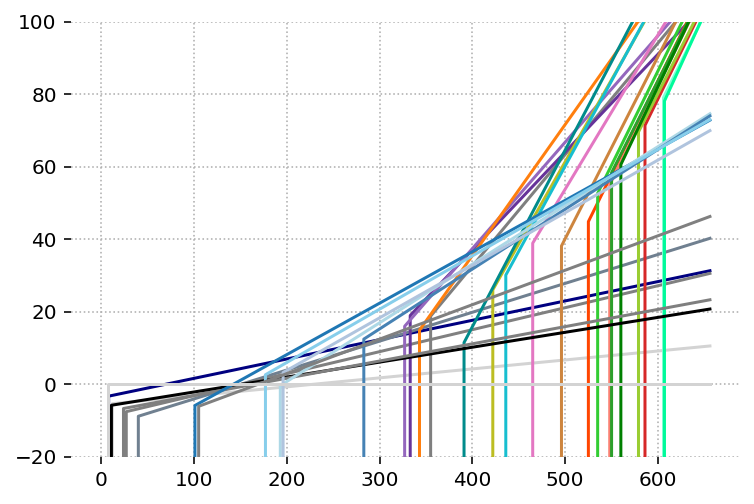

In [348]:
for i in range(l0.shape[-1]):
    plt.plot(l0[0,...,i]+lb[0,i], c=lineage_colors[merged_lineages_alias[i]])
plt.ylim((-20,100))

In [349]:
bak.loc[bak.index.str.startswith("B.1"),:]

counts       date
B.1.1.7      97128 2021-01-11
B.1.617.2    20392 2021-04-12
B.1.177.86    3505 2021-01-08
B.1.177.81    3064 2021-01-08
B.1.177       2792 2021-01-04
B.1           2519 2021-01-06
B.1.221       2370 2021-01-05
B.1.160       2077 2021-01-04
B.1.351       1941 2021-01-18
B.1.1         1915 2021-01-06
B.1.258       1885 2021-01-09
B.1.1.529     1451 2022-01-06
B.1.1.317     1234 2021-01-16
B.1.177.62     903 2021-01-12
B.1.525        860 2021-02-01
B.1.258.17     749 2021-01-18
B.1.1.318      520 2021-02-19
B.1.1.70       426 2021-01-11
B.1.177.75     301 2021-01-08
B.1.1.385      277 2021-01-12
B.1.619        239 2021-03-17
B.1.1.519      232 2021-02-08
B.1.1.39       232 2021-01-14
B.1.1.297      224 2021-01-14
B.1.2          208 2021-01-20
B.1.221.2      191 2021-01-07
B.1.177.77     163 2021-01-12
B.1.9.4        161 2021-01-20
B.1.177.83     152 2021-01-25

In [350]:
pd.Series(GG[-1].sum(0), index=merged_lineages_alias)

A               693.0
B.1.1.7       97698.0
P.1             923.0
B.1.1.318      1173.0
B.1.1.529      1526.0
BA.1          57444.0
BA.1.1       109826.0
BA.2         261252.0
BA.2.12.1      3924.0
BA.2.75         108.0
BA.2.75.1        52.0
BA.2.75.2        39.0
BA.4           6480.0
BA.4.6          800.0
BA.5          75965.0
BA.5.2        38695.0
BF.7           2317.0
BF.11           174.0
BF.13            51.0
BF.14           110.0
BQ.1             20.0
BQ.1.1           12.0
B.1.351        1975.0
B.1.525         860.0
B.1.617.2    175406.0
AY.4.2         3098.0
AY.36.1        2221.0
AY.43         49174.0
AY.46.6        8701.0
B.1.621         165.0
B             30570.0
dtype: float64

In [208]:
CC[-1,-10:]

array([19500.        , 15597.        , 77573.        , 94598.73889807,
       86586.93202063, 73661.2761355 , 69610.05761328, 20078.0634574 ,
       11549.08765736, 13041.27803952])

In [210]:
cases_land.columns

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2022-09-24', '2022-09-25', '2022-09-26', '2022-09-27',
               '2022-09-28', '2022-09-29', '2022-09-30', '2022-10-01',
               '2022-10-02', '2022-10-03'],
              dtype='datetime64[ns]', name='Refdatum', length=641, freq=None)

In [220]:
B1.shape

NameError: name 'B1' is not defined

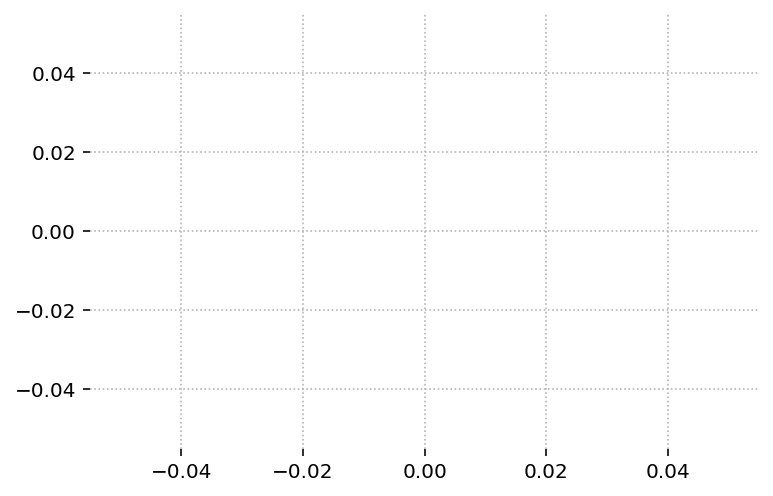

In [445]:
plt.plot(lse)
plt.plot(B0[0] @ lse[np.linspace(0,B0.shape[1]-1, B0.shape[2]).astype("int")])

In [446]:
lse

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na